# KE5105 - Building Electrical Consumption Forecasting

# Modelling 6 - Preliminary model and Fine-tuning

## Summary of Findings
* Base 4x128 GRU, 2x32 Dense Layer Model
	* Minimum Validation MAE (normalised) = 1.814 (0.0170) @ epoch 64
* Dropout (0.2) and Recurrent Dropout (0.2)
	* Validation MAE = 4.005 @ last epoch 200
* Dropout (0.2) and No Recurrent Dropout
	* Min Validation MAE = 2.641
* No Dropout and Recurrent Dropout (0.2)
	* Minimum Validation MAE = 1.904215

## Load libraries

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/Documents/KE5105/ETL',
 '/home/tkokkeng/python/python367/tsfvenv/lib',
 '/home/tkokkeng/Documents/KE5105/ETL/source',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython']

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import datetime
import myUtilities as mu
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

## Load data for building AS5

In [5]:
as5 = mu.load_data_by_bldg(['AS5'], 'processed')

In [6]:
as5[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62880 entries, 2015-06-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         46164 non-null float64
PWMEXTAS4ExBldg                   46165 non-null float64
PWMAS4LanguageCenter              46165 non-null float64
PWMCANTEEN                        46164 non-null float64
PWMStreetLight                    46164 non-null float64
BTUAS5                            46175 non-null float64
PWMMainIC_30min_avg               46117 non-null float64
PWMEXTAS4ExBldg_30min_avg         46118 non-null float64
PWMAS4LanguageCenter_30min_avg    46118 non-null float64
PWMCANTEEN_30min_avg              46117 non-null float64
PWMStreetLight_30min_avg          46117 non-null float64
BTUAS5_30min_avg                  46129 non-null float64
PWM_sumadd                        46117 non-null float64
PWM_sumsubtract                   46117 non-null float64
PWM_30min_avg                     46117 non-null float64
B

## Split the data into train and test set

In [6]:
as5_train_df = as5[0][1].loc['2015-06-12 08:00:00':'2017-03-31 23:30:00', :]

In [7]:
as5_train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31616 entries, 2015-06-12 08:00:00 to 2017-03-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         30018 non-null float64
PWMEXTAS4ExBldg                   30018 non-null float64
PWMAS4LanguageCenter              30018 non-null float64
PWMCANTEEN                        30018 non-null float64
PWMStreetLight                    30018 non-null float64
BTUAS5                            30029 non-null float64
PWMMainIC_30min_avg               29985 non-null float64
PWMEXTAS4ExBldg_30min_avg         29985 non-null float64
PWMAS4LanguageCenter_30min_avg    29985 non-null float64
PWMCANTEEN_30min_avg              29985 non-null float64
PWMStreetLight_30min_avg          29985 non-null float64
BTUAS5_30min_avg                  29998 non-null float64
PWM_sumadd                        29985 non-null float64
PWM_sumsubtract                   29985 non-null float64
PWM_30min_avg                     29985 non-null float64
B

In [8]:
as5_test_df = as5[0][1].loc['2018-01-01 00:00:00':, :]

In [10]:
as5_test_df.index.max()

Timestamp('2018-12-31 23:30:00')

In [11]:
as5_test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2018-01-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         16145 non-null float64
PWMEXTAS4ExBldg                   16145 non-null float64
PWMAS4LanguageCenter              16145 non-null float64
PWMCANTEEN                        16145 non-null float64
PWMStreetLight                    16145 non-null float64
BTUAS5                            16144 non-null float64
PWMMainIC_30min_avg               16132 non-null float64
PWMEXTAS4ExBldg_30min_avg         16132 non-null float64
PWMAS4LanguageCenter_30min_avg    16132 non-null float64
PWMCANTEEN_30min_avg              16132 non-null float64
PWMStreetLight_30min_avg          16132 non-null float64
BTUAS5_30min_avg                  16130 non-null float64
PWM_sumadd                        16132 non-null float64
PWM_sumsubtract                   16132 non-null float64
PWM_30min_avg                     16132 non-null float64
B

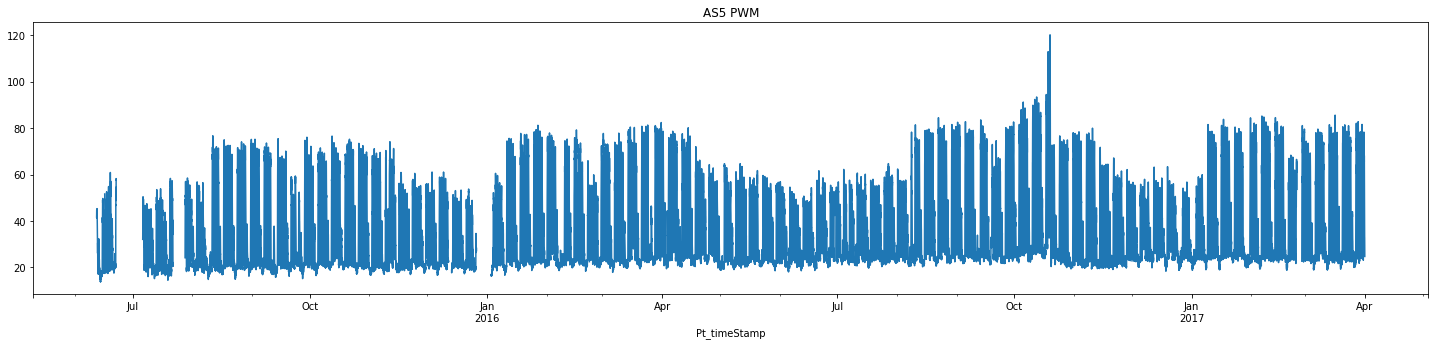

In [12]:
as5_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='AS5 PWM')

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [13]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

## Normalise the training data

* Convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [14]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [15]:
as5_train_data = my_pipeline.fit_transform(as5_train_df)
as5_train_data

array([[ 0.26254935,  0.56924225],
       [ 0.26724948,  0.53427896],
       [ 0.28031585,  0.53353241],
       ...,
       [ 0.12897161,  0.03222595],
       [ 0.10312089,  0.00348389],
       [-1.        , -1.        ]])

Text(0.5, 1.0, 'Normalised PWM Training Data')

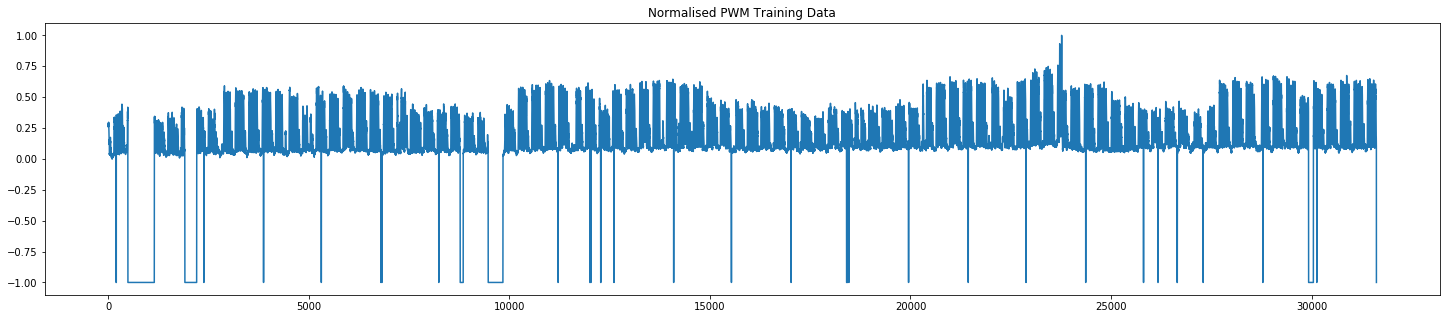

In [16]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0])
plt.title('Normalised PWM Training Data')

Text(0.5, 1.0, 'Normalised BTU Training Data')

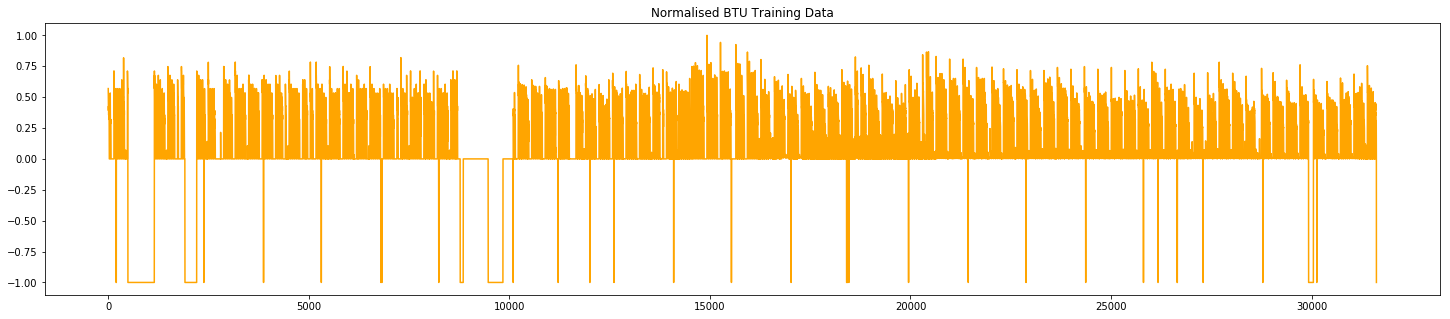

In [17]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

## Split a validation set out from the train set

In [18]:
as5_train_split = as5_train_data[:20000]
as5_val_split = as5_train_data[20000:]

In [19]:
print('train split = %s\nvalidation split = %s' % (as5_train_split.shape, as5_val_split.shape))

train split = (20000, 2)
validation split = (11616, 2)


## 4x128 GRU, 2x32 Dense Layer Model 

In [20]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [21]:
model = Sequential()
model.add(layers.CuDNNGRU(128, return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.CuDNNGRU(128, return_sequences=True))
model.add(layers.CuDNNGRU(128, return_sequences=True))
model.add(layers.CuDNNGRU(128))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [22]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


### Train the RNN

In [22]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-epch100-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-epch100.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50304     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         98688     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         98688     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [23]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=300,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/300


 - 13s - loss: 0.0693 - mean_absolute_percentage_error: 45.4536 - val_loss: 0.0469 - val_mean_absolute_percentage_error: 30.5952


Epoch 2/300


 - 12s - loss: 0.0409 - mean_absolute_percentage_error: 27.5409 - val_loss: 0.0357 - val_mean_absolute_percentage_error: 18.9450


Epoch 3/300


 - 12s - loss: 0.0361 - mean_absolute_percentage_error: 24.0111 - val_loss: 0.0291 - val_mean_absolute_percentage_error: 15.4303


Epoch 4/300


 - 12s - loss: 0.0319 - mean_absolute_percentage_error: 22.6963 - val_loss: 0.0269 - val_mean_absolute_percentage_error: 16.8304


Epoch 5/300


 - 12s - loss: 0.0299 - mean_absolute_percentage_error: 21.0028 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 12.5814


Epoch 6/300


 - 12s - loss: 0.0281 - mean_absolute_percentage_error: 18.9890 - val_loss: 0.0189 - val_mean_absolute_percentage_error: 9.4280


Epoch 7/300


 - 12s - loss: 0.0268 - mean_absolute_percentage_error: 18.6272 - val_loss: 0.0369 - val_mean_absolute_percentage_error: 19.0232


Epoch 8/300


 - 12s - loss: 0.0264 - mean_absolute_percentage_error: 18.0133 - val_loss: 0.0318 - val_mean_absolute_percentage_error: 12.2188


Epoch 9/300


 - 12s - loss: 0.0252 - mean_absolute_percentage_error: 17.0411 - val_loss: 0.0315 - val_mean_absolute_percentage_error: 12.2451


Epoch 10/300


 - 12s - loss: 0.0247 - mean_absolute_percentage_error: 16.6227 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 12.1568


Epoch 11/300


 - 12s - loss: 0.0238 - mean_absolute_percentage_error: 16.3756 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 10.5210


Epoch 12/300


 - 12s - loss: 0.0234 - mean_absolute_percentage_error: 15.8074 - val_loss: 0.0301 - val_mean_absolute_percentage_error: 12.1263


Epoch 13/300


 - 12s - loss: 0.0230 - mean_absolute_percentage_error: 15.5129 - val_loss: 0.0306 - val_mean_absolute_percentage_error: 13.6245


Epoch 14/300


 - 12s - loss: 0.0224 - mean_absolute_percentage_error: 15.1190 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 13.8232


Epoch 15/300


 - 12s - loss: 0.0225 - mean_absolute_percentage_error: 15.2929 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 11.4184


Epoch 16/300


 - 12s - loss: 0.0221 - mean_absolute_percentage_error: 15.3060 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 9.4630


Epoch 17/300


 - 12s - loss: 0.0221 - mean_absolute_percentage_error: 15.1410 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 12.8336


Epoch 18/300


 - 12s - loss: 0.0214 - mean_absolute_percentage_error: 14.5733 - val_loss: 0.0285 - val_mean_absolute_percentage_error: 18.5600


Epoch 19/300


 - 12s - loss: 0.0217 - mean_absolute_percentage_error: 14.6844 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 10.6056


Epoch 20/300


 - 12s - loss: 0.0211 - mean_absolute_percentage_error: 14.3863 - val_loss: 0.0214 - val_mean_absolute_percentage_error: 12.0083


Epoch 21/300


 - 12s - loss: 0.0212 - mean_absolute_percentage_error: 14.6044 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 10.4522


Epoch 22/300


 - 12s - loss: 0.0213 - mean_absolute_percentage_error: 14.5483 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 10.7875


Epoch 23/300


 - 12s - loss: 0.0208 - mean_absolute_percentage_error: 14.6696 - val_loss: 0.0242 - val_mean_absolute_percentage_error: 12.6857


Epoch 24/300


 - 12s - loss: 0.0206 - mean_absolute_percentage_error: 13.9877 - val_loss: 0.0331 - val_mean_absolute_percentage_error: 21.5728


Epoch 25/300


 - 12s - loss: 0.0207 - mean_absolute_percentage_error: 14.4372 - val_loss: 0.0218 - val_mean_absolute_percentage_error: 11.3674


Epoch 26/300


 - 12s - loss: 0.0202 - mean_absolute_percentage_error: 13.8109 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 15.3737


Epoch 27/300


 - 12s - loss: 0.0202 - mean_absolute_percentage_error: 13.6988 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 8.9603


Epoch 28/300


 - 12s - loss: 0.0201 - mean_absolute_percentage_error: 13.8640 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 9.6469


Epoch 29/300


 - 12s - loss: 0.0200 - mean_absolute_percentage_error: 14.0769 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 11.6184


Epoch 30/300


 - 12s - loss: 0.0198 - mean_absolute_percentage_error: 13.9254 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 9.0960


Epoch 31/300


 - 12s - loss: 0.0196 - mean_absolute_percentage_error: 13.5635 - val_loss: 0.0193 - val_mean_absolute_percentage_error: 9.2122


Epoch 32/300


 - 12s - loss: 0.0196 - mean_absolute_percentage_error: 13.5259 - val_loss: 0.0291 - val_mean_absolute_percentage_error: 11.9796


Epoch 33/300


 - 12s - loss: 0.0193 - mean_absolute_percentage_error: 13.4178 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 9.1663


Epoch 34/300


 - 12s - loss: 0.0189 - mean_absolute_percentage_error: 12.9617 - val_loss: 0.0209 - val_mean_absolute_percentage_error: 10.4354


Epoch 35/300


 - 12s - loss: 0.0190 - mean_absolute_percentage_error: 13.4814 - val_loss: 0.0229 - val_mean_absolute_percentage_error: 13.2369


Epoch 36/300


 - 12s - loss: 0.0192 - mean_absolute_percentage_error: 13.4284 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 8.8973


Epoch 37/300


 - 12s - loss: 0.0186 - mean_absolute_percentage_error: 12.9172 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 9.0358


Epoch 38/300


 - 12s - loss: 0.0187 - mean_absolute_percentage_error: 12.6298 - val_loss: 0.0180 - val_mean_absolute_percentage_error: 9.3905


Epoch 39/300


 - 12s - loss: 0.0186 - mean_absolute_percentage_error: 12.7376 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 11.8495


Epoch 40/300


 - 12s - loss: 0.0184 - mean_absolute_percentage_error: 12.9348 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 10.1207


Epoch 41/300


 - 12s - loss: 0.0186 - mean_absolute_percentage_error: 12.7684 - val_loss: 0.0217 - val_mean_absolute_percentage_error: 9.3945


Epoch 42/300


 - 12s - loss: 0.0179 - mean_absolute_percentage_error: 12.5336 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 16.5611


Epoch 43/300


 - 12s - loss: 0.0178 - mean_absolute_percentage_error: 12.2879 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 9.1060


Epoch 44/300


 - 12s - loss: 0.0178 - mean_absolute_percentage_error: 12.3976 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 12.9169


Epoch 45/300


 - 12s - loss: 0.0175 - mean_absolute_percentage_error: 12.5220 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 8.9610


Epoch 46/300


 - 12s - loss: 0.0177 - mean_absolute_percentage_error: 12.1643 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 9.5726


Epoch 47/300


 - 12s - loss: 0.0176 - mean_absolute_percentage_error: 12.3401 - val_loss: 0.0269 - val_mean_absolute_percentage_error: 11.1958


Epoch 48/300


 - 12s - loss: 0.0172 - mean_absolute_percentage_error: 11.8343 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 10.5908


Epoch 49/300


 - 12s - loss: 0.0172 - mean_absolute_percentage_error: 11.9862 - val_loss: 0.0189 - val_mean_absolute_percentage_error: 9.0858


Epoch 50/300


 - 12s - loss: 0.0171 - mean_absolute_percentage_error: 11.9391 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 10.6454


Epoch 51/300


 - 12s - loss: 0.0172 - mean_absolute_percentage_error: 12.1348 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 9.1065


Epoch 52/300


 - 12s - loss: 0.0169 - mean_absolute_percentage_error: 11.9882 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 12.2760


Epoch 53/300


 - 12s - loss: 0.0169 - mean_absolute_percentage_error: 11.6903 - val_loss: 0.0252 - val_mean_absolute_percentage_error: 11.8413


Epoch 54/300


 - 12s - loss: 0.0169 - mean_absolute_percentage_error: 11.8251 - val_loss: 0.0184 - val_mean_absolute_percentage_error: 8.7775


Epoch 55/300


 - 12s - loss: 0.0165 - mean_absolute_percentage_error: 11.6967 - val_loss: 0.0209 - val_mean_absolute_percentage_error: 9.2926


Epoch 56/300


 - 12s - loss: 0.0167 - mean_absolute_percentage_error: 11.4461 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 10.1983


Epoch 57/300


 - 12s - loss: 0.0163 - mean_absolute_percentage_error: 11.3734 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 10.3360


Epoch 58/300


 - 12s - loss: 0.0163 - mean_absolute_percentage_error: 11.2189 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 9.0166


Epoch 59/300


 - 12s - loss: 0.0162 - mean_absolute_percentage_error: 11.3828 - val_loss: 0.0229 - val_mean_absolute_percentage_error: 11.4661


Epoch 60/300


 - 12s - loss: 0.0160 - mean_absolute_percentage_error: 11.1051 - val_loss: 0.0219 - val_mean_absolute_percentage_error: 9.7804


Epoch 61/300


 - 12s - loss: 0.0161 - mean_absolute_percentage_error: 11.1799 - val_loss: 0.0207 - val_mean_absolute_percentage_error: 9.6776


Epoch 62/300


 - 12s - loss: 0.0158 - mean_absolute_percentage_error: 10.8327 - val_loss: 0.0214 - val_mean_absolute_percentage_error: 9.1754


Epoch 63/300


 - 12s - loss: 0.0158 - mean_absolute_percentage_error: 11.1257 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 8.4051


Epoch 64/300


 - 12s - loss: 0.0159 - mean_absolute_percentage_error: 11.0722 - val_loss: 0.0207 - val_mean_absolute_percentage_error: 10.7104


Epoch 65/300


 - 12s - loss: 0.0156 - mean_absolute_percentage_error: 10.5637 - val_loss: 0.0170 - val_mean_absolute_percentage_error: 8.3122


Epoch 66/300


 - 12s - loss: 0.0154 - mean_absolute_percentage_error: 10.6376 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 9.2966


Epoch 67/300


 - 12s - loss: 0.0154 - mean_absolute_percentage_error: 10.6832 - val_loss: 0.0243 - val_mean_absolute_percentage_error: 11.2859


Epoch 68/300


 - 12s - loss: 0.0156 - mean_absolute_percentage_error: 10.7461 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 8.9631


Epoch 69/300


 - 12s - loss: 0.0154 - mean_absolute_percentage_error: 10.6408 - val_loss: 0.0187 - val_mean_absolute_percentage_error: 9.3483


Epoch 70/300


 - 12s - loss: 0.0153 - mean_absolute_percentage_error: 10.3829 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 9.0745


Epoch 71/300


 - 12s - loss: 0.0153 - mean_absolute_percentage_error: 10.6802 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 9.5382


Epoch 72/300


 - 12s - loss: 0.0152 - mean_absolute_percentage_error: 10.6191 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 8.9908


Epoch 73/300


 - 12s - loss: 0.0150 - mean_absolute_percentage_error: 10.3461 - val_loss: 0.0228 - val_mean_absolute_percentage_error: 9.8483


Epoch 74/300


 - 12s - loss: 0.0149 - mean_absolute_percentage_error: 10.3289 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 8.6121


Epoch 75/300


 - 12s - loss: 0.0149 - mean_absolute_percentage_error: 10.2440 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 8.4082


Epoch 76/300


 - 12s - loss: 0.0150 - mean_absolute_percentage_error: 10.3362 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 10.6602


Epoch 77/300


 - 12s - loss: 0.0150 - mean_absolute_percentage_error: 10.4698 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 8.4330


Epoch 78/300


 - 12s - loss: 0.0146 - mean_absolute_percentage_error: 10.1529 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 9.3387


Epoch 79/300


 - 12s - loss: 0.0147 - mean_absolute_percentage_error: 10.1179 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 9.8000


Epoch 80/300


 - 12s - loss: 0.0146 - mean_absolute_percentage_error: 10.2012 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 9.1125


Epoch 81/300


 - 12s - loss: 0.0144 - mean_absolute_percentage_error: 9.8847 - val_loss: 0.0225 - val_mean_absolute_percentage_error: 10.7999


Epoch 82/300


 - 12s - loss: 0.0145 - mean_absolute_percentage_error: 9.9509 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 8.6855


Epoch 83/300


 - 12s - loss: 0.0145 - mean_absolute_percentage_error: 10.2379 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 8.4952


Epoch 84/300


 - 12s - loss: 0.0145 - mean_absolute_percentage_error: 9.8180 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 9.6049


Epoch 85/300


 - 12s - loss: 0.0142 - mean_absolute_percentage_error: 9.8043 - val_loss: 0.0193 - val_mean_absolute_percentage_error: 9.1352


Epoch 86/300


 - 12s - loss: 0.0143 - mean_absolute_percentage_error: 9.9220 - val_loss: 0.0176 - val_mean_absolute_percentage_error: 8.2190


Epoch 87/300


 - 12s - loss: 0.0142 - mean_absolute_percentage_error: 9.8864 - val_loss: 0.0174 - val_mean_absolute_percentage_error: 8.0664


Epoch 88/300


 - 12s - loss: 0.0143 - mean_absolute_percentage_error: 9.8227 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 10.0304


Epoch 89/300


 - 12s - loss: 0.0141 - mean_absolute_percentage_error: 9.9116 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 9.7116


Epoch 90/300


 - 12s - loss: 0.0140 - mean_absolute_percentage_error: 9.6177 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 10.1498


Epoch 91/300


 - 12s - loss: 0.0140 - mean_absolute_percentage_error: 9.7943 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 9.5526


Epoch 92/300


 - 12s - loss: 0.0139 - mean_absolute_percentage_error: 9.5179 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 8.7570


Epoch 93/300


 - 12s - loss: 0.0139 - mean_absolute_percentage_error: 9.7608 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 8.9730


Epoch 94/300


 - 12s - loss: 0.0136 - mean_absolute_percentage_error: 9.3862 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 8.1733


Epoch 95/300


 - 12s - loss: 0.0138 - mean_absolute_percentage_error: 9.5119 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 9.1943


Epoch 96/300


 - 12s - loss: 0.0137 - mean_absolute_percentage_error: 9.4636 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 8.6123


Epoch 97/300


 - 12s - loss: 0.0137 - mean_absolute_percentage_error: 9.6729 - val_loss: 0.0214 - val_mean_absolute_percentage_error: 9.8183


Epoch 98/300


 - 12s - loss: 0.0136 - mean_absolute_percentage_error: 9.4326 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 9.2406


Epoch 99/300


 - 12s - loss: 0.0135 - mean_absolute_percentage_error: 9.3552 - val_loss: 0.0206 - val_mean_absolute_percentage_error: 9.3783


Epoch 100/300


 - 12s - loss: 0.0134 - mean_absolute_percentage_error: 9.4089 - val_loss: 0.0218 - val_mean_absolute_percentage_error: 9.0662


Epoch 101/300


 - 12s - loss: 0.0134 - mean_absolute_percentage_error: 9.3524 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 8.7264


Epoch 102/300


 - 12s - loss: 0.0131 - mean_absolute_percentage_error: 9.2054 - val_loss: 0.0245 - val_mean_absolute_percentage_error: 9.7589


Epoch 103/300


 - 12s - loss: 0.0132 - mean_absolute_percentage_error: 9.1440 - val_loss: 0.0218 - val_mean_absolute_percentage_error: 9.0271


Epoch 104/300


 - 12s - loss: 0.0132 - mean_absolute_percentage_error: 9.1786 - val_loss: 0.0184 - val_mean_absolute_percentage_error: 8.3700


Epoch 105/300


 - 12s - loss: 0.0131 - mean_absolute_percentage_error: 9.1246 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 8.9338


Epoch 106/300


 - 12s - loss: 0.0130 - mean_absolute_percentage_error: 9.1149 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 8.7413


Epoch 107/300


 - 12s - loss: 0.0129 - mean_absolute_percentage_error: 9.1718 - val_loss: 0.0235 - val_mean_absolute_percentage_error: 9.3998


Epoch 108/300


 - 12s - loss: 0.0130 - mean_absolute_percentage_error: 9.2580 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 9.5294


Epoch 109/300


 - 12s - loss: 0.0128 - mean_absolute_percentage_error: 9.1010 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 9.8020


Epoch 110/300


 - 12s - loss: 0.0128 - mean_absolute_percentage_error: 8.9307 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 8.7672


Epoch 111/300


 - 12s - loss: 0.0127 - mean_absolute_percentage_error: 8.7931 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 9.3744


Epoch 112/300


 - 12s - loss: 0.0125 - mean_absolute_percentage_error: 8.9406 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 11.4160


Epoch 113/300


 - 12s - loss: 0.0125 - mean_absolute_percentage_error: 8.8529 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 8.6295


Epoch 114/300


 - 12s - loss: 0.0125 - mean_absolute_percentage_error: 8.7762 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 8.5720


Epoch 115/300


 - 12s - loss: 0.0126 - mean_absolute_percentage_error: 8.7995 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 9.7127


Epoch 116/300


 - 12s - loss: 0.0122 - mean_absolute_percentage_error: 8.7143 - val_loss: 0.0191 - val_mean_absolute_percentage_error: 8.6296


Epoch 117/300


 - 12s - loss: 0.0123 - mean_absolute_percentage_error: 8.6146 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 8.6891


Epoch 118/300


 - 12s - loss: 0.0122 - mean_absolute_percentage_error: 8.6417 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 9.0282


Epoch 119/300


 - 12s - loss: 0.0121 - mean_absolute_percentage_error: 8.5236 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 9.1212


Epoch 120/300


 - 12s - loss: 0.0122 - mean_absolute_percentage_error: 8.6850 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 9.6552


Epoch 121/300


 - 12s - loss: 0.0118 - mean_absolute_percentage_error: 8.6421 - val_loss: 0.0213 - val_mean_absolute_percentage_error: 9.1782


Epoch 122/300


 - 12s - loss: 0.0121 - mean_absolute_percentage_error: 8.6881 - val_loss: 0.0193 - val_mean_absolute_percentage_error: 8.7981


Epoch 123/300


 - 12s - loss: 0.0117 - mean_absolute_percentage_error: 8.5128 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 9.1343


Epoch 124/300


 - 12s - loss: 0.0116 - mean_absolute_percentage_error: 8.4354 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 8.6574


Epoch 125/300


 - 12s - loss: 0.0118 - mean_absolute_percentage_error: 8.4074 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 8.8762


Epoch 126/300


 - 12s - loss: 0.0115 - mean_absolute_percentage_error: 8.4252 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 8.8162


Epoch 127/300


 - 12s - loss: 0.0116 - mean_absolute_percentage_error: 8.4658 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 8.7866


Epoch 128/300


 - 12s - loss: 0.0115 - mean_absolute_percentage_error: 8.3322 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 9.9922


Epoch 129/300


 - 12s - loss: 0.0114 - mean_absolute_percentage_error: 8.1986 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 8.8961


Epoch 130/300


 - 12s - loss: 0.0113 - mean_absolute_percentage_error: 8.1178 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 8.9215


Epoch 131/300


 - 12s - loss: 0.0113 - mean_absolute_percentage_error: 8.0433 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 9.4175


Epoch 132/300


 - 12s - loss: 0.0113 - mean_absolute_percentage_error: 8.2969 - val_loss: 0.0241 - val_mean_absolute_percentage_error: 9.8433


Epoch 133/300


 - 13s - loss: 0.0112 - mean_absolute_percentage_error: 8.0047 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 9.1024


Epoch 134/300


 - 12s - loss: 0.0113 - mean_absolute_percentage_error: 8.1209 - val_loss: 0.0209 - val_mean_absolute_percentage_error: 9.9299


Epoch 135/300


 - 13s - loss: 0.0110 - mean_absolute_percentage_error: 8.0262 - val_loss: 0.0211 - val_mean_absolute_percentage_error: 9.3440


Epoch 136/300


 - 13s - loss: 0.0109 - mean_absolute_percentage_error: 7.9372 - val_loss: 0.0238 - val_mean_absolute_percentage_error: 9.5472


Epoch 137/300


 - 13s - loss: 0.0110 - mean_absolute_percentage_error: 7.8327 - val_loss: 0.0224 - val_mean_absolute_percentage_error: 10.3110


Epoch 138/300


 - 13s - loss: 0.0107 - mean_absolute_percentage_error: 7.8904 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 10.3079


Epoch 139/300


 - 13s - loss: 0.0107 - mean_absolute_percentage_error: 7.8410 - val_loss: 0.0241 - val_mean_absolute_percentage_error: 10.0706


Epoch 140/300


 - 13s - loss: 0.0108 - mean_absolute_percentage_error: 8.0154 - val_loss: 0.0212 - val_mean_absolute_percentage_error: 9.7090


Epoch 141/300


 - 13s - loss: 0.0105 - mean_absolute_percentage_error: 7.6714 - val_loss: 0.0214 - val_mean_absolute_percentage_error: 9.3934


Epoch 142/300


 - 13s - loss: 0.0108 - mean_absolute_percentage_error: 7.8987 - val_loss: 0.0220 - val_mean_absolute_percentage_error: 9.5082


Epoch 143/300


 - 13s - loss: 0.0103 - mean_absolute_percentage_error: 7.6847 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 11.5392


Epoch 144/300


 - 13s - loss: 0.0105 - mean_absolute_percentage_error: 7.8615 - val_loss: 0.0220 - val_mean_absolute_percentage_error: 9.2649


Epoch 145/300


 - 13s - loss: 0.0103 - mean_absolute_percentage_error: 7.5569 - val_loss: 0.0219 - val_mean_absolute_percentage_error: 9.9707


Epoch 146/300


 - 13s - loss: 0.0102 - mean_absolute_percentage_error: 7.7023 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 9.1151


Epoch 147/300


 - 13s - loss: 0.0102 - mean_absolute_percentage_error: 7.6114 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 9.0802


Epoch 148/300


 - 13s - loss: 0.0102 - mean_absolute_percentage_error: 7.5019 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 9.2885


Epoch 149/300


 - 12s - loss: 0.0101 - mean_absolute_percentage_error: 7.5462 - val_loss: 0.0224 - val_mean_absolute_percentage_error: 9.6555


Epoch 150/300


 - 13s - loss: 0.0101 - mean_absolute_percentage_error: 7.4305 - val_loss: 0.0224 - val_mean_absolute_percentage_error: 11.3295


Epoch 151/300


 - 12s - loss: 0.0099 - mean_absolute_percentage_error: 7.4461 - val_loss: 0.0217 - val_mean_absolute_percentage_error: 9.4123


Epoch 152/300


 - 13s - loss: 0.0099 - mean_absolute_percentage_error: 7.3741 - val_loss: 0.0212 - val_mean_absolute_percentage_error: 9.4665


Epoch 153/300


 - 13s - loss: 0.0097 - mean_absolute_percentage_error: 7.3338 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 9.4111


Epoch 154/300


 - 13s - loss: 0.0098 - mean_absolute_percentage_error: 7.3667 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 10.2052


Epoch 155/300


 - 13s - loss: 0.0097 - mean_absolute_percentage_error: 7.1749 - val_loss: 0.0224 - val_mean_absolute_percentage_error: 9.4234


Epoch 156/300


 - 13s - loss: 0.0097 - mean_absolute_percentage_error: 7.3212 - val_loss: 0.0211 - val_mean_absolute_percentage_error: 9.2911


Epoch 157/300


 - 13s - loss: 0.0095 - mean_absolute_percentage_error: 7.1624 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 9.4075


Epoch 158/300


 - 13s - loss: 0.0094 - mean_absolute_percentage_error: 7.2010 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 9.3926


Epoch 159/300


 - 13s - loss: 0.0095 - mean_absolute_percentage_error: 7.0889 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 9.2428


Epoch 160/300


 - 13s - loss: 0.0094 - mean_absolute_percentage_error: 7.0254 - val_loss: 0.0251 - val_mean_absolute_percentage_error: 9.9889


Epoch 161/300


 - 13s - loss: 0.0094 - mean_absolute_percentage_error: 7.1494 - val_loss: 0.0245 - val_mean_absolute_percentage_error: 9.7159


Epoch 162/300


 - 13s - loss: 0.0093 - mean_absolute_percentage_error: 7.0653 - val_loss: 0.0214 - val_mean_absolute_percentage_error: 9.1443


Epoch 163/300


 - 13s - loss: 0.0092 - mean_absolute_percentage_error: 7.0530 - val_loss: 0.0217 - val_mean_absolute_percentage_error: 9.2343


Epoch 164/300


 - 13s - loss: 0.0092 - mean_absolute_percentage_error: 6.8907 - val_loss: 0.0225 - val_mean_absolute_percentage_error: 10.1954


Epoch 165/300


 - 13s - loss: 0.0091 - mean_absolute_percentage_error: 6.8792 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 11.1250


Epoch 166/300


 - 12s - loss: 0.0090 - mean_absolute_percentage_error: 6.9618 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 11.3727


Epoch 167/300


 - 12s - loss: 0.0090 - mean_absolute_percentage_error: 6.7514 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 9.4546


Epoch 168/300


 - 13s - loss: 0.0091 - mean_absolute_percentage_error: 6.8436 - val_loss: 0.0236 - val_mean_absolute_percentage_error: 10.2341


Epoch 169/300


 - 13s - loss: 0.0089 - mean_absolute_percentage_error: 6.6673 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 9.8825


Epoch 170/300


 - 13s - loss: 0.0088 - mean_absolute_percentage_error: 6.7887 - val_loss: 0.0237 - val_mean_absolute_percentage_error: 9.6982


Epoch 171/300


 - 13s - loss: 0.0089 - mean_absolute_percentage_error: 6.7381 - val_loss: 0.0238 - val_mean_absolute_percentage_error: 9.6426


Epoch 172/300


 - 13s - loss: 0.0087 - mean_absolute_percentage_error: 6.6989 - val_loss: 0.0225 - val_mean_absolute_percentage_error: 9.5996


Epoch 173/300


 - 12s - loss: 0.0087 - mean_absolute_percentage_error: 6.6862 - val_loss: 0.0211 - val_mean_absolute_percentage_error: 9.4286


Epoch 174/300


 - 13s - loss: 0.0086 - mean_absolute_percentage_error: 6.6573 - val_loss: 0.0206 - val_mean_absolute_percentage_error: 9.2464


Epoch 175/300


 - 13s - loss: 0.0086 - mean_absolute_percentage_error: 6.7999 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 9.4243


Epoch 176/300


 - 13s - loss: 0.0085 - mean_absolute_percentage_error: 6.4181 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 9.5362


Epoch 177/300


 - 13s - loss: 0.0085 - mean_absolute_percentage_error: 6.3735 - val_loss: 0.0212 - val_mean_absolute_percentage_error: 9.5033


Epoch 178/300


 - 13s - loss: 0.0085 - mean_absolute_percentage_error: 6.5112 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 9.2897


Epoch 179/300


 - 13s - loss: 0.0083 - mean_absolute_percentage_error: 6.4668 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 9.5341


Epoch 180/300


 - 12s - loss: 0.0085 - mean_absolute_percentage_error: 6.4666 - val_loss: 0.0240 - val_mean_absolute_percentage_error: 10.7767


Epoch 181/300


 - 12s - loss: 0.0083 - mean_absolute_percentage_error: 6.3587 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 9.5789


Epoch 182/300


 - 12s - loss: 0.0082 - mean_absolute_percentage_error: 6.4277 - val_loss: 0.0213 - val_mean_absolute_percentage_error: 9.5187


Epoch 183/300


 - 12s - loss: 0.0083 - mean_absolute_percentage_error: 6.3430 - val_loss: 0.0246 - val_mean_absolute_percentage_error: 11.2751


Epoch 184/300


 - 12s - loss: 0.0082 - mean_absolute_percentage_error: 6.3777 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 9.8443


Epoch 185/300


 - 12s - loss: 0.0080 - mean_absolute_percentage_error: 6.4060 - val_loss: 0.0211 - val_mean_absolute_percentage_error: 9.4508


Epoch 186/300


 - 12s - loss: 0.0082 - mean_absolute_percentage_error: 6.1884 - val_loss: 0.0220 - val_mean_absolute_percentage_error: 9.5081


Epoch 187/300


 - 12s - loss: 0.0081 - mean_absolute_percentage_error: 6.2433 - val_loss: 0.0228 - val_mean_absolute_percentage_error: 9.6784


Epoch 188/300


 - 12s - loss: 0.0080 - mean_absolute_percentage_error: 6.2505 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 9.5279


Epoch 189/300


 - 12s - loss: 0.0080 - mean_absolute_percentage_error: 6.3428 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 10.4618


Epoch 190/300


 - 12s - loss: 0.0081 - mean_absolute_percentage_error: 6.2585 - val_loss: 0.0235 - val_mean_absolute_percentage_error: 9.8303


Epoch 191/300


 - 12s - loss: 0.0079 - mean_absolute_percentage_error: 6.2471 - val_loss: 0.0235 - val_mean_absolute_percentage_error: 9.7490


Epoch 192/300


 - 12s - loss: 0.0079 - mean_absolute_percentage_error: 6.0943 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 9.7219


Epoch 193/300


 - 12s - loss: 0.0079 - mean_absolute_percentage_error: 6.3065 - val_loss: 0.0238 - val_mean_absolute_percentage_error: 9.9546


Epoch 194/300


 - 12s - loss: 0.0077 - mean_absolute_percentage_error: 5.9137 - val_loss: 0.0211 - val_mean_absolute_percentage_error: 9.3773


Epoch 195/300


 - 12s - loss: 0.0079 - mean_absolute_percentage_error: 6.1905 - val_loss: 0.0249 - val_mean_absolute_percentage_error: 10.0969


Epoch 196/300


 - 12s - loss: 0.0078 - mean_absolute_percentage_error: 6.2257 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 9.4110


Epoch 197/300


 - 12s - loss: 0.0077 - mean_absolute_percentage_error: 6.0451 - val_loss: 0.0237 - val_mean_absolute_percentage_error: 11.1501


Epoch 198/300


 - 12s - loss: 0.0077 - mean_absolute_percentage_error: 6.0304 - val_loss: 0.0243 - val_mean_absolute_percentage_error: 10.0703


Epoch 199/300


 - 12s - loss: 0.0076 - mean_absolute_percentage_error: 6.1181 - val_loss: 0.0225 - val_mean_absolute_percentage_error: 10.0957


Epoch 200/300


 - 12s - loss: 0.0075 - mean_absolute_percentage_error: 5.8573 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 9.9426


Epoch 201/300


 - 12s - loss: 0.0076 - mean_absolute_percentage_error: 6.0198 - val_loss: 0.0212 - val_mean_absolute_percentage_error: 9.5128


Epoch 202/300


 - 12s - loss: 0.0074 - mean_absolute_percentage_error: 5.8259 - val_loss: 0.0246 - val_mean_absolute_percentage_error: 10.0584


Epoch 203/300


 - 12s - loss: 0.0077 - mean_absolute_percentage_error: 5.9418 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 10.7017


Epoch 204/300


 - 12s - loss: 0.0074 - mean_absolute_percentage_error: 5.8402 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 9.6482


Epoch 205/300


 - 12s - loss: 0.0074 - mean_absolute_percentage_error: 5.7994 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 10.1704


Epoch 206/300


 - 12s - loss: 0.0072 - mean_absolute_percentage_error: 5.6413 - val_loss: 0.0229 - val_mean_absolute_percentage_error: 9.8854


Epoch 207/300


 - 12s - loss: 0.0075 - mean_absolute_percentage_error: 5.8431 - val_loss: 0.0224 - val_mean_absolute_percentage_error: 9.5761


Epoch 208/300


 - 12s - loss: 0.0076 - mean_absolute_percentage_error: 5.8959 - val_loss: 0.0221 - val_mean_absolute_percentage_error: 9.7280


Epoch 209/300


 - 12s - loss: 0.0072 - mean_absolute_percentage_error: 5.4900 - val_loss: 0.0217 - val_mean_absolute_percentage_error: 9.4834


Epoch 210/300


 - 12s - loss: 0.0073 - mean_absolute_percentage_error: 5.7013 - val_loss: 0.0224 - val_mean_absolute_percentage_error: 9.5725


Epoch 211/300


 - 12s - loss: 0.0073 - mean_absolute_percentage_error: 5.5681 - val_loss: 0.0225 - val_mean_absolute_percentage_error: 9.7109


Epoch 212/300


 - 12s - loss: 0.0073 - mean_absolute_percentage_error: 5.7062 - val_loss: 0.0207 - val_mean_absolute_percentage_error: 9.4600


Epoch 213/300


 - 12s - loss: 0.0070 - mean_absolute_percentage_error: 5.4831 - val_loss: 0.0228 - val_mean_absolute_percentage_error: 10.0514


Epoch 214/300


 - 12s - loss: 0.0073 - mean_absolute_percentage_error: 5.7061 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 10.4931


Epoch 215/300


 - 12s - loss: 0.0072 - mean_absolute_percentage_error: 5.6510 - val_loss: 0.0239 - val_mean_absolute_percentage_error: 10.5269


Epoch 216/300


 - 12s - loss: 0.0070 - mean_absolute_percentage_error: 5.3232 - val_loss: 0.0213 - val_mean_absolute_percentage_error: 9.6529


Epoch 217/300


 - 12s - loss: 0.0070 - mean_absolute_percentage_error: 5.5277 - val_loss: 0.0229 - val_mean_absolute_percentage_error: 10.3179


Epoch 218/300


 - 12s - loss: 0.0070 - mean_absolute_percentage_error: 5.4482 - val_loss: 0.0234 - val_mean_absolute_percentage_error: 9.9947


Epoch 219/300


 - 12s - loss: 0.0071 - mean_absolute_percentage_error: 5.5036 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 9.5842


Epoch 220/300


 - 12s - loss: 0.0070 - mean_absolute_percentage_error: 5.4492 - val_loss: 0.0238 - val_mean_absolute_percentage_error: 9.8474


Epoch 221/300


 - 12s - loss: 0.0069 - mean_absolute_percentage_error: 5.3843 - val_loss: 0.0251 - val_mean_absolute_percentage_error: 10.5794


Epoch 222/300


 - 12s - loss: 0.0069 - mean_absolute_percentage_error: 5.3996 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 10.2568


Epoch 223/300


 - 12s - loss: 0.0070 - mean_absolute_percentage_error: 5.4746 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 10.1205


Epoch 224/300


 - 12s - loss: 0.0069 - mean_absolute_percentage_error: 5.3959 - val_loss: 0.0229 - val_mean_absolute_percentage_error: 9.9436


Epoch 225/300


 - 12s - loss: 0.0069 - mean_absolute_percentage_error: 5.2778 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 10.1081


Epoch 226/300


 - 12s - loss: 0.0067 - mean_absolute_percentage_error: 5.2994 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 11.5930


Epoch 227/300


 - 12s - loss: 0.0068 - mean_absolute_percentage_error: 5.2751 - val_loss: 0.0236 - val_mean_absolute_percentage_error: 10.0919


Epoch 228/300


 - 12s - loss: 0.0068 - mean_absolute_percentage_error: 5.4065 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 9.8757


Epoch 229/300


 - 12s - loss: 0.0066 - mean_absolute_percentage_error: 5.2362 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 9.7580


Epoch 230/300


 - 12s - loss: 0.0067 - mean_absolute_percentage_error: 5.3407 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 10.2910


Epoch 231/300


 - 12s - loss: 0.0066 - mean_absolute_percentage_error: 5.1473 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 12.4019


Epoch 232/300


 - 12s - loss: 0.0067 - mean_absolute_percentage_error: 5.2663 - val_loss: 0.0245 - val_mean_absolute_percentage_error: 10.5818


Epoch 233/300


 - 13s - loss: 0.0066 - mean_absolute_percentage_error: 5.2090 - val_loss: 0.0214 - val_mean_absolute_percentage_error: 10.1263


Epoch 234/300


 - 12s - loss: 0.0066 - mean_absolute_percentage_error: 5.1655 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 9.7988


Epoch 235/300


 - 12s - loss: 0.0066 - mean_absolute_percentage_error: 5.2446 - val_loss: 0.0213 - val_mean_absolute_percentage_error: 9.6000


Epoch 236/300


 - 12s - loss: 0.0066 - mean_absolute_percentage_error: 5.0980 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 9.7921


Epoch 237/300


 - 12s - loss: 0.0065 - mean_absolute_percentage_error: 5.1108 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 9.9564


Epoch 238/300


 - 13s - loss: 0.0065 - mean_absolute_percentage_error: 5.1108 - val_loss: 0.0211 - val_mean_absolute_percentage_error: 9.8228


Epoch 239/300


 - 12s - loss: 0.0066 - mean_absolute_percentage_error: 5.1057 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 9.9164


Epoch 240/300


 - 13s - loss: 0.0065 - mean_absolute_percentage_error: 4.9873 - val_loss: 0.0245 - val_mean_absolute_percentage_error: 10.2929


Epoch 241/300


 - 12s - loss: 0.0064 - mean_absolute_percentage_error: 5.1250 - val_loss: 0.0236 - val_mean_absolute_percentage_error: 9.9220


Epoch 242/300


 - 12s - loss: 0.0065 - mean_absolute_percentage_error: 5.2165 - val_loss: 0.0238 - val_mean_absolute_percentage_error: 10.0681


Epoch 243/300


 - 13s - loss: 0.0063 - mean_absolute_percentage_error: 4.9711 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 10.5447


Epoch 244/300


 - 13s - loss: 0.0063 - mean_absolute_percentage_error: 4.9380 - val_loss: 0.0225 - val_mean_absolute_percentage_error: 9.8580


Epoch 245/300


 - 12s - loss: 0.0062 - mean_absolute_percentage_error: 5.0190 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 9.8408


Epoch 246/300


 - 12s - loss: 0.0065 - mean_absolute_percentage_error: 5.0325 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 10.2564


Epoch 247/300


 - 12s - loss: 0.0064 - mean_absolute_percentage_error: 4.9124 - val_loss: 0.0225 - val_mean_absolute_percentage_error: 9.8271


Epoch 248/300


 - 12s - loss: 0.0063 - mean_absolute_percentage_error: 4.8917 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 10.1899


Epoch 249/300


 - 12s - loss: 0.0063 - mean_absolute_percentage_error: 4.8699 - val_loss: 0.0231 - val_mean_absolute_percentage_error: 10.5853


Epoch 250/300


 - 12s - loss: 0.0063 - mean_absolute_percentage_error: 4.9497 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 9.7739


Epoch 251/300


 - 12s - loss: 0.0063 - mean_absolute_percentage_error: 4.8125 - val_loss: 0.0241 - val_mean_absolute_percentage_error: 10.1988


Epoch 252/300


 - 12s - loss: 0.0062 - mean_absolute_percentage_error: 4.7717 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 10.5539


Epoch 253/300


 - 13s - loss: 0.0061 - mean_absolute_percentage_error: 4.7577 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 10.2082


Epoch 254/300


 - 13s - loss: 0.0061 - mean_absolute_percentage_error: 4.8655 - val_loss: 0.0221 - val_mean_absolute_percentage_error: 9.8687


Epoch 255/300


 - 13s - loss: 0.0060 - mean_absolute_percentage_error: 4.7504 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 10.2865


Epoch 256/300


 - 13s - loss: 0.0062 - mean_absolute_percentage_error: 4.7188 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 9.8753


Epoch 257/300


 - 13s - loss: 0.0062 - mean_absolute_percentage_error: 4.8454 - val_loss: 0.0219 - val_mean_absolute_percentage_error: 9.7155


Epoch 258/300


 - 13s - loss: 0.0060 - mean_absolute_percentage_error: 4.7716 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 10.5295


Epoch 259/300


 - 13s - loss: 0.0061 - mean_absolute_percentage_error: 4.8274 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 10.0492


Epoch 260/300


 - 13s - loss: 0.0061 - mean_absolute_percentage_error: 4.7214 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 10.3944


Epoch 261/300


 - 13s - loss: 0.0060 - mean_absolute_percentage_error: 4.6230 - val_loss: 0.0239 - val_mean_absolute_percentage_error: 10.0821


Epoch 262/300


 - 13s - loss: 0.0060 - mean_absolute_percentage_error: 4.7349 - val_loss: 0.0235 - val_mean_absolute_percentage_error: 9.9972


Epoch 263/300


 - 12s - loss: 0.0060 - mean_absolute_percentage_error: 4.6246 - val_loss: 0.0241 - val_mean_absolute_percentage_error: 10.4334


Epoch 264/300


 - 12s - loss: 0.0060 - mean_absolute_percentage_error: 4.6887 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 10.2110


Epoch 265/300


 - 12s - loss: 0.0060 - mean_absolute_percentage_error: 4.6244 - val_loss: 0.0248 - val_mean_absolute_percentage_error: 10.4433


Epoch 266/300


 - 12s - loss: 0.0059 - mean_absolute_percentage_error: 4.7219 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 9.8844


Epoch 267/300


 - 12s - loss: 0.0060 - mean_absolute_percentage_error: 4.6649 - val_loss: 0.0234 - val_mean_absolute_percentage_error: 10.0426


Epoch 268/300


 - 12s - loss: 0.0059 - mean_absolute_percentage_error: 4.5075 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 9.9821


Epoch 269/300


 - 12s - loss: 0.0060 - mean_absolute_percentage_error: 4.6098 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 10.9632


Epoch 270/300


 - 12s - loss: 0.0058 - mean_absolute_percentage_error: 4.5678 - val_loss: 0.0251 - val_mean_absolute_percentage_error: 10.5551


Epoch 271/300


 - 12s - loss: 0.0058 - mean_absolute_percentage_error: 4.5784 - val_loss: 0.0241 - val_mean_absolute_percentage_error: 10.3966


Epoch 272/300


 - 12s - loss: 0.0059 - mean_absolute_percentage_error: 4.7087 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 9.8419


Epoch 273/300


 - 12s - loss: 0.0057 - mean_absolute_percentage_error: 4.5388 - val_loss: 0.0224 - val_mean_absolute_percentage_error: 9.8935


Epoch 274/300


 - 12s - loss: 0.0059 - mean_absolute_percentage_error: 4.5550 - val_loss: 0.0212 - val_mean_absolute_percentage_error: 9.8718


Epoch 275/300


 - 12s - loss: 0.0058 - mean_absolute_percentage_error: 4.3707 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 10.2571


Epoch 276/300


 - 12s - loss: 0.0059 - mean_absolute_percentage_error: 4.4077 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 10.9259


Epoch 277/300


 - 12s - loss: 0.0057 - mean_absolute_percentage_error: 4.4936 - val_loss: 0.0225 - val_mean_absolute_percentage_error: 10.1719


Epoch 278/300


 - 12s - loss: 0.0057 - mean_absolute_percentage_error: 4.4795 - val_loss: 0.0238 - val_mean_absolute_percentage_error: 10.1877


Epoch 279/300


 - 12s - loss: 0.0057 - mean_absolute_percentage_error: 4.4252 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 10.0571


Epoch 280/300


 - 12s - loss: 0.0057 - mean_absolute_percentage_error: 4.4354 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 10.0416


Epoch 281/300


 - 12s - loss: 0.0056 - mean_absolute_percentage_error: 4.3692 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 10.0652


Epoch 282/300


 - 12s - loss: 0.0057 - mean_absolute_percentage_error: 4.3697 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 10.1589


Epoch 283/300


 - 12s - loss: 0.0057 - mean_absolute_percentage_error: 4.4647 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 10.0009


Epoch 284/300


 - 12s - loss: 0.0055 - mean_absolute_percentage_error: 4.3963 - val_loss: 0.0248 - val_mean_absolute_percentage_error: 10.6913


Epoch 285/300


 - 12s - loss: 0.0056 - mean_absolute_percentage_error: 4.4104 - val_loss: 0.0245 - val_mean_absolute_percentage_error: 10.8284


Epoch 286/300


 - 12s - loss: 0.0056 - mean_absolute_percentage_error: 4.2838 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 10.4702


Epoch 287/300


 - 12s - loss: 0.0056 - mean_absolute_percentage_error: 4.3069 - val_loss: 0.0243 - val_mean_absolute_percentage_error: 10.6007


Epoch 288/300


 - 12s - loss: 0.0056 - mean_absolute_percentage_error: 4.3768 - val_loss: 0.0220 - val_mean_absolute_percentage_error: 9.9555


Epoch 289/300


 - 12s - loss: 0.0056 - mean_absolute_percentage_error: 4.4217 - val_loss: 0.0221 - val_mean_absolute_percentage_error: 9.9193


Epoch 290/300


 - 12s - loss: 0.0055 - mean_absolute_percentage_error: 4.2715 - val_loss: 0.0238 - val_mean_absolute_percentage_error: 10.0743


Epoch 291/300


 - 12s - loss: 0.0057 - mean_absolute_percentage_error: 4.3207 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 10.2620


Epoch 292/300


 - 12s - loss: 0.0055 - mean_absolute_percentage_error: 4.2266 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 10.0810


Epoch 293/300


 - 12s - loss: 0.0055 - mean_absolute_percentage_error: 4.2410 - val_loss: 0.0239 - val_mean_absolute_percentage_error: 10.4047


Epoch 294/300


 - 12s - loss: 0.0056 - mean_absolute_percentage_error: 4.3960 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 10.2882


Epoch 295/300


 - 12s - loss: 0.0055 - mean_absolute_percentage_error: 4.1051 - val_loss: 0.0219 - val_mean_absolute_percentage_error: 9.9779


Epoch 296/300


 - 12s - loss: 0.0054 - mean_absolute_percentage_error: 4.1541 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 10.0654


Epoch 297/300


 - 13s - loss: 0.0055 - mean_absolute_percentage_error: 4.2550 - val_loss: 0.0217 - val_mean_absolute_percentage_error: 9.9206


Epoch 298/300


 - 13s - loss: 0.0054 - mean_absolute_percentage_error: 4.1508 - val_loss: 0.0251 - val_mean_absolute_percentage_error: 10.2495


Epoch 299/300


 - 12s - loss: 0.0055 - mean_absolute_percentage_error: 4.3072 - val_loss: 0.0242 - val_mean_absolute_percentage_error: 10.3234


Epoch 300/300


 - 12s - loss: 0.0055 - mean_absolute_percentage_error: 4.1568 - val_loss: 0.0228 - val_mean_absolute_percentage_error: 10.0580



Training Duration = 1:00:32.924669


In [26]:
# histories = []  ## if first training session
histories.append(history.history)

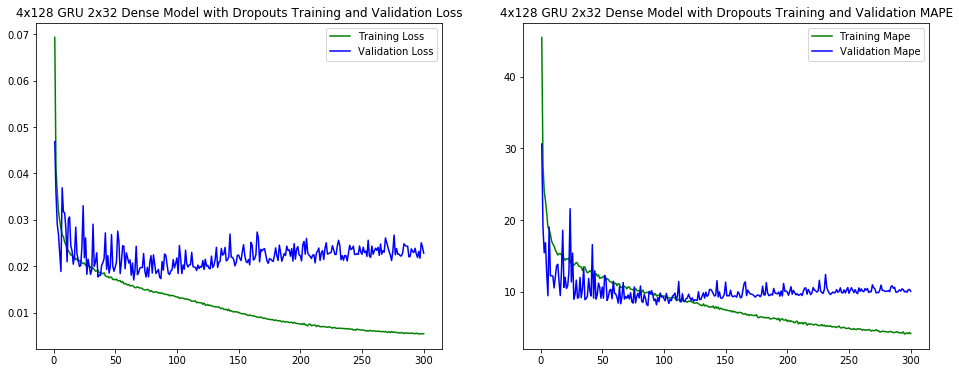

In [27]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation MAPE')
plt.legend()
plt.show()

In [31]:
print('min validation loss = {}\nepoch = {}'.format(min(val_loss), val_loss.index(min(val_loss))))

min validation loss = 0.01704749922028022
epoch = 64


In [29]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 0.577209
Validation MAE = 1.813513


In [32]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

(29754, 1)

In [33]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

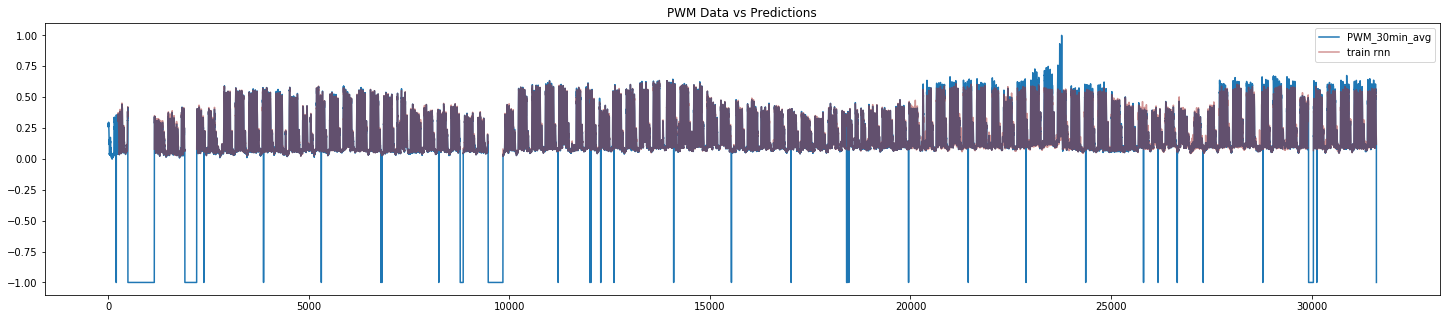

In [34]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

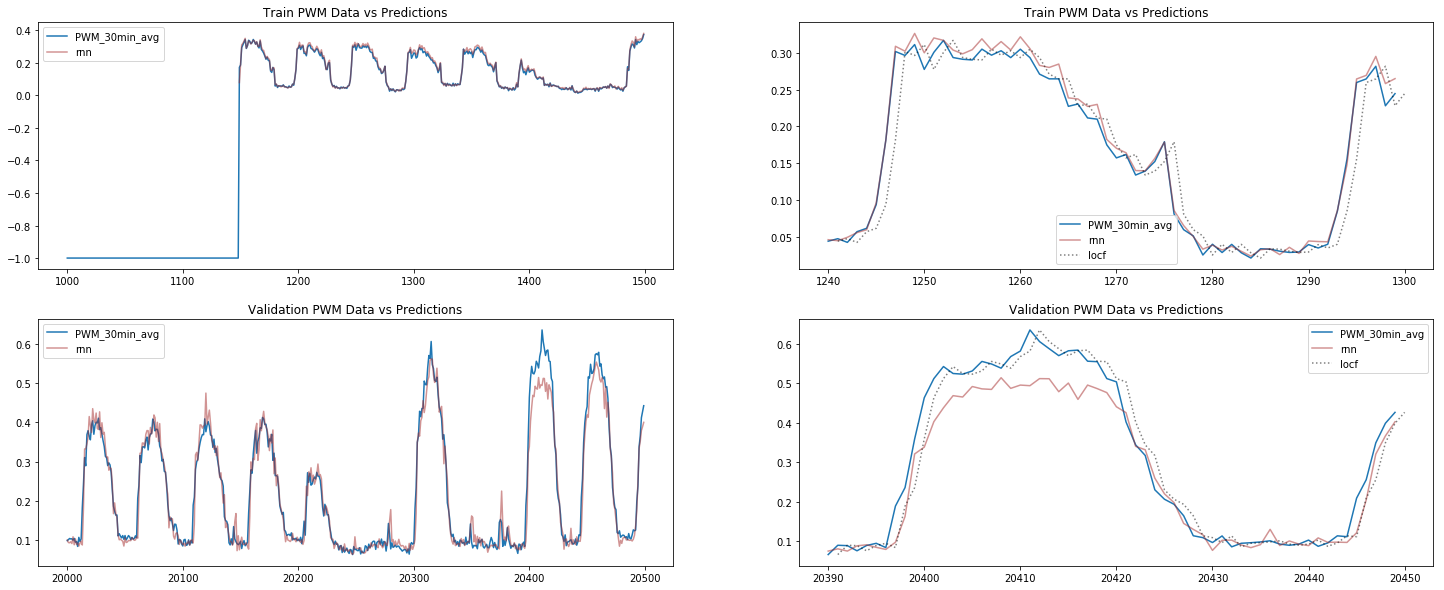

In [35]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [36]:
model.save('base-4x128gru-2x32dense-epch300.h5')

In [37]:
with open('base-4x128gru-2x32dense-epch300-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with Dropout (0.2) and Recurrent Dropout (0.2)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [20]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [21]:
gen_train.__len__()

143

In [22]:
gen_val.__len__()

88

In [34]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout-history.pkl'), 'rb') as infile:
    history = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout.h5'))
model.summary()

In [45]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50

 - 94s - loss: 0.0184 - mean_absolute_percentage_error: 12.4129 - val_loss: 0.0495 - val_mean_absolute_percentage_error: 21.6401


Epoch 2/50


 - 93s - loss: 0.0183 - mean_absolute_percentage_error: 12.2700 - val_loss: 0.0411 - val_mean_absolute_percentage_error: 18.0239


Epoch 3/50


 - 93s - loss: 0.0184 - mean_absolute_percentage_error: 12.3692 - val_loss: 0.0411 - val_mean_absolute_percentage_error: 18.3144


Epoch 4/50


 - 92s - loss: 0.0182 - mean_absolute_percentage_error: 12.2837 - val_loss: 0.0417 - val_mean_absolute_percentage_error: 17.1902


Epoch 5/50


 - 93s - loss: 0.0183 - mean_absolute_percentage_error: 12.3216 - val_loss: 0.0439 - val_mean_absolute_percentage_error: 17.7521


Epoch 6/50


 - 93s - loss: 0.0182 - mean_absolute_percentage_error: 12.2927 - val_loss: 0.0473 - val_mean_absolute_percentage_error: 19.8470


Epoch 7/50


 - 93s - loss: 0.0181 - mean_absolute_percentage_error: 12.1725 - val_loss: 0.0456 - val_mean_absolute_percentage_error: 18.5817


Epoch 8/50


 - 92s - loss: 0.0182 - mean_absolute_percentage_error: 12.2131 - val_loss: 0.0372 - val_mean_absolute_percentage_error: 16.0326


Epoch 9/50


 - 93s - loss: 0.0180 - mean_absolute_percentage_error: 12.1874 - val_loss: 0.0531 - val_mean_absolute_percentage_error: 25.4666


Epoch 10/50


 - 93s - loss: 0.0185 - mean_absolute_percentage_error: 12.4049 - val_loss: 0.0437 - val_mean_absolute_percentage_error: 17.0128


Epoch 11/50


 - 94s - loss: 0.0184 - mean_absolute_percentage_error: 12.2703 - val_loss: 0.0496 - val_mean_absolute_percentage_error: 22.2575


Epoch 12/50


 - 94s - loss: 0.0183 - mean_absolute_percentage_error: 12.4125 - val_loss: 0.0466 - val_mean_absolute_percentage_error: 20.0208


Epoch 13/50


 - 92s - loss: 0.0185 - mean_absolute_percentage_error: 12.3864 - val_loss: 0.0483 - val_mean_absolute_percentage_error: 20.2903


Epoch 14/50


 - 92s - loss: 0.0182 - mean_absolute_percentage_error: 12.1818 - val_loss: 0.0341 - val_mean_absolute_percentage_error: 13.4802


Epoch 15/50


 - 93s - loss: 0.0179 - mean_absolute_percentage_error: 12.1235 - val_loss: 0.0513 - val_mean_absolute_percentage_error: 22.8080


Epoch 16/50


 - 92s - loss: 0.0180 - mean_absolute_percentage_error: 12.1314 - val_loss: 0.0448 - val_mean_absolute_percentage_error: 17.6384


Epoch 17/50


 - 93s - loss: 0.0179 - mean_absolute_percentage_error: 12.1121 - val_loss: 0.0493 - val_mean_absolute_percentage_error: 25.6860


Epoch 18/50


 - 92s - loss: 0.0178 - mean_absolute_percentage_error: 12.1939 - val_loss: 0.0508 - val_mean_absolute_percentage_error: 24.2912


Epoch 19/50


 - 92s - loss: 0.0176 - mean_absolute_percentage_error: 12.0166 - val_loss: 0.0437 - val_mean_absolute_percentage_error: 17.8212


Epoch 20/50


 - 92s - loss: 0.0181 - mean_absolute_percentage_error: 12.1281 - val_loss: 0.0524 - val_mean_absolute_percentage_error: 22.5249


Epoch 21/50


 - 92s - loss: 0.0179 - mean_absolute_percentage_error: 12.1751 - val_loss: 0.0451 - val_mean_absolute_percentage_error: 19.1311


Epoch 22/50


 - 92s - loss: 0.0178 - mean_absolute_percentage_error: 12.0985 - val_loss: 0.0459 - val_mean_absolute_percentage_error: 21.7084


Epoch 23/50


 - 92s - loss: 0.0177 - mean_absolute_percentage_error: 11.9150 - val_loss: 0.0431 - val_mean_absolute_percentage_error: 18.6704


Epoch 24/50


 - 93s - loss: 0.0179 - mean_absolute_percentage_error: 12.0624 - val_loss: 0.0530 - val_mean_absolute_percentage_error: 21.5533


Epoch 25/50


 - 92s - loss: 0.0181 - mean_absolute_percentage_error: 12.0585 - val_loss: 0.0484 - val_mean_absolute_percentage_error: 24.0887


Epoch 26/50


 - 92s - loss: 0.0178 - mean_absolute_percentage_error: 12.1604 - val_loss: 0.0441 - val_mean_absolute_percentage_error: 19.2965


Epoch 27/50


 - 92s - loss: 0.0178 - mean_absolute_percentage_error: 12.0022 - val_loss: 0.0352 - val_mean_absolute_percentage_error: 16.7145


Epoch 28/50


 - 92s - loss: 0.0180 - mean_absolute_percentage_error: 12.0087 - val_loss: 0.0431 - val_mean_absolute_percentage_error: 18.1758


Epoch 29/50


 - 92s - loss: 0.0179 - mean_absolute_percentage_error: 11.8931 - val_loss: 0.0477 - val_mean_absolute_percentage_error: 20.1646


Epoch 30/50


 - 92s - loss: 0.0176 - mean_absolute_percentage_error: 11.7059 - val_loss: 0.0460 - val_mean_absolute_percentage_error: 23.2795


Epoch 31/50


 - 92s - loss: 0.0175 - mean_absolute_percentage_error: 11.8132 - val_loss: 0.0443 - val_mean_absolute_percentage_error: 21.6463


Epoch 32/50


 - 92s - loss: 0.0177 - mean_absolute_percentage_error: 11.7756 - val_loss: 0.0383 - val_mean_absolute_percentage_error: 15.1824


Epoch 33/50


 - 92s - loss: 0.0178 - mean_absolute_percentage_error: 11.9731 - val_loss: 0.0538 - val_mean_absolute_percentage_error: 24.5379


Epoch 34/50


 - 93s - loss: 0.0175 - mean_absolute_percentage_error: 11.9671 - val_loss: 0.0495 - val_mean_absolute_percentage_error: 21.5396


Epoch 35/50


 - 92s - loss: 0.0175 - mean_absolute_percentage_error: 11.8297 - val_loss: 0.0449 - val_mean_absolute_percentage_error: 21.1778


Epoch 36/50


 - 93s - loss: 0.0175 - mean_absolute_percentage_error: 12.0002 - val_loss: 0.0462 - val_mean_absolute_percentage_error: 19.8544


Epoch 37/50


 - 93s - loss: 0.0176 - mean_absolute_percentage_error: 11.6635 - val_loss: 0.0436 - val_mean_absolute_percentage_error: 20.1899


Epoch 38/50


 - 92s - loss: 0.0178 - mean_absolute_percentage_error: 12.0100 - val_loss: 0.0394 - val_mean_absolute_percentage_error: 16.2103


Epoch 39/50


 - 93s - loss: 0.0178 - mean_absolute_percentage_error: 11.9251 - val_loss: 0.0457 - val_mean_absolute_percentage_error: 18.8444


Epoch 40/50


 - 92s - loss: 0.0176 - mean_absolute_percentage_error: 11.7774 - val_loss: 0.0473 - val_mean_absolute_percentage_error: 19.2457


Epoch 41/50


 - 93s - loss: 0.0176 - mean_absolute_percentage_error: 11.9046 - val_loss: 0.0469 - val_mean_absolute_percentage_error: 21.6150


Epoch 42/50


 - 92s - loss: 0.0174 - mean_absolute_percentage_error: 11.6434 - val_loss: 0.0425 - val_mean_absolute_percentage_error: 19.2412


Epoch 43/50


 - 92s - loss: 0.0175 - mean_absolute_percentage_error: 11.7934 - val_loss: 0.0527 - val_mean_absolute_percentage_error: 25.5111


Epoch 44/50


 - 92s - loss: 0.0175 - mean_absolute_percentage_error: 11.8624 - val_loss: 0.0419 - val_mean_absolute_percentage_error: 17.3205


Epoch 45/50


 - 94s - loss: 0.0178 - mean_absolute_percentage_error: 11.8597 - val_loss: 0.0563 - val_mean_absolute_percentage_error: 25.3599


Epoch 46/50


 - 94s - loss: 0.0174 - mean_absolute_percentage_error: 11.7887 - val_loss: 0.0376 - val_mean_absolute_percentage_error: 18.0748


Epoch 47/50


 - 93s - loss: 0.0176 - mean_absolute_percentage_error: 11.8688 - val_loss: 0.0427 - val_mean_absolute_percentage_error: 20.3972


Epoch 48/50


 - 94s - loss: 0.0173 - mean_absolute_percentage_error: 11.6149 - val_loss: 0.0417 - val_mean_absolute_percentage_error: 16.7719


Epoch 49/50


 - 92s - loss: 0.0176 - mean_absolute_percentage_error: 11.8132 - val_loss: 0.0364 - val_mean_absolute_percentage_error: 14.4619


Epoch 50/50


 - 93s - loss: 0.0172 - mean_absolute_percentage_error: 11.6482 - val_loss: 0.0376 - val_mean_absolute_percentage_error: 16.5731



Training Duration = 1:17:12.182388


In [46]:
histories.append(history.history)

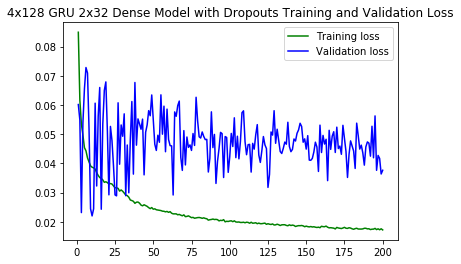

In [47]:
train_loss = []
val_loss = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.show()

In [52]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (val_loss[-1] * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.834166
Validation MAE = 4.005036


In [53]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=True)
as5_train_preds.shape

(29754, 1)

In [54]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

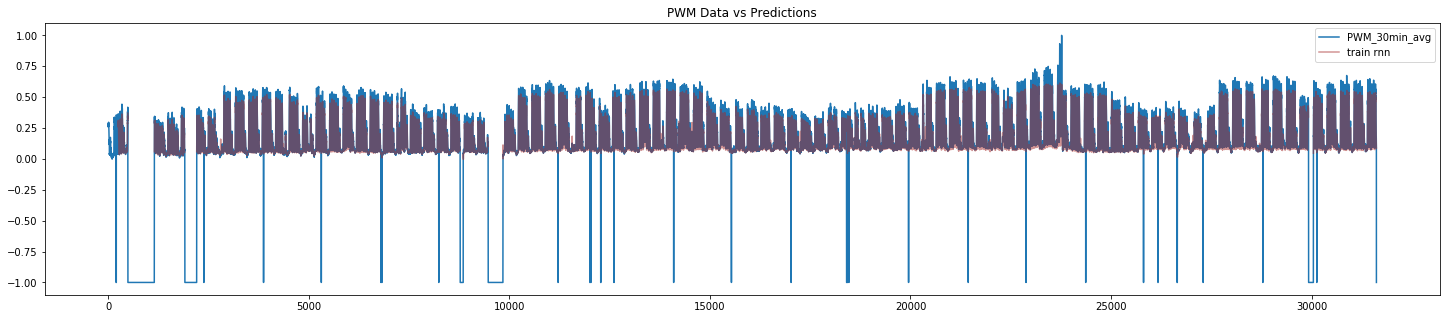

In [55]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

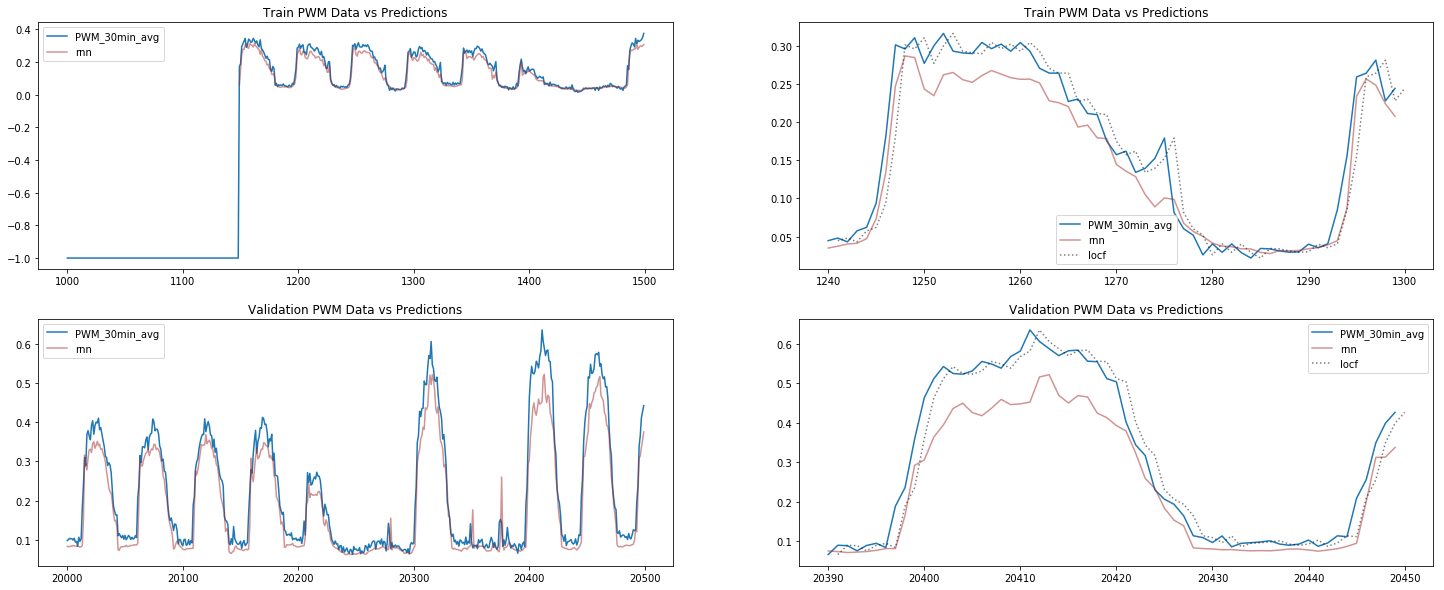

In [56]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [57]:
model.save('base-4x128gru-2x32dense-dropout0202.h5')

In [58]:
with open('base-4x128gru-2x32dense-dropout0202-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with Dropout (0.2) and No Recurrent Dropout

In [20]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])


In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [22]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [33]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout0200-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout0200.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [23]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50


 - 86s - loss: 0.0843 - mean_absolute_percentage_error: 51.2702 - val_loss: 0.0604 - val_mean_absolute_percentage_error: 23.5358


Epoch 2/50


 - 83s - loss: 0.0605 - mean_absolute_percentage_error: 37.4005 - val_loss: 0.0900 - val_mean_absolute_percentage_error: 38.3364


Epoch 3/50


 - 83s - loss: 0.0513 - mean_absolute_percentage_error: 30.8312 - val_loss: 0.0938 - val_mean_absolute_percentage_error: 30.6236


Epoch 4/50


 - 83s - loss: 0.0475 - mean_absolute_percentage_error: 29.5986 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 12.9550


Epoch 5/50


 - 83s - loss: 0.0444 - mean_absolute_percentage_error: 28.0224 - val_loss: 0.0522 - val_mean_absolute_percentage_error: 18.3554


Epoch 6/50


 - 83s - loss: 0.0426 - mean_absolute_percentage_error: 26.0586 - val_loss: 0.0737 - val_mean_absolute_percentage_error: 29.8102


Epoch 7/50


 - 83s - loss: 0.0407 - mean_absolute_percentage_error: 25.3983 - val_loss: 0.0558 - val_mean_absolute_percentage_error: 20.8350


Epoch 8/50


 - 83s - loss: 0.0391 - mean_absolute_percentage_error: 24.6472 - val_loss: 0.0423 - val_mean_absolute_percentage_error: 15.6414


Epoch 9/50


 - 83s - loss: 0.0383 - mean_absolute_percentage_error: 23.4407 - val_loss: 0.0577 - val_mean_absolute_percentage_error: 19.5284


Epoch 10/50


 - 83s - loss: 0.0385 - mean_absolute_percentage_error: 23.7500 - val_loss: 0.0609 - val_mean_absolute_percentage_error: 25.8534


Epoch 11/50


 - 83s - loss: 0.0371 - mean_absolute_percentage_error: 23.3094 - val_loss: 0.0666 - val_mean_absolute_percentage_error: 36.9750


Epoch 12/50


 - 83s - loss: 0.0361 - mean_absolute_percentage_error: 22.3282 - val_loss: 0.0657 - val_mean_absolute_percentage_error: 23.2774


Epoch 13/50


 - 83s - loss: 0.0360 - mean_absolute_percentage_error: 22.2000 - val_loss: 0.0512 - val_mean_absolute_percentage_error: 17.4286


Epoch 14/50


 - 83s - loss: 0.0348 - mean_absolute_percentage_error: 21.5192 - val_loss: 0.0483 - val_mean_absolute_percentage_error: 16.2361


Epoch 15/50


 - 83s - loss: 0.0349 - mean_absolute_percentage_error: 22.1125 - val_loss: 0.0510 - val_mean_absolute_percentage_error: 19.5550


Epoch 16/50


 - 83s - loss: 0.0342 - mean_absolute_percentage_error: 20.9820 - val_loss: 0.0315 - val_mean_absolute_percentage_error: 13.8315


Epoch 17/50


 - 83s - loss: 0.0333 - mean_absolute_percentage_error: 20.8801 - val_loss: 0.0248 - val_mean_absolute_percentage_error: 11.0898


Epoch 18/50


 - 83s - loss: 0.0327 - mean_absolute_percentage_error: 20.2440 - val_loss: 0.0304 - val_mean_absolute_percentage_error: 17.3859


Epoch 19/50


 - 85s - loss: 0.0334 - mean_absolute_percentage_error: 20.5952 - val_loss: 0.0404 - val_mean_absolute_percentage_error: 15.3736


Epoch 20/50


 - 85s - loss: 0.0329 - mean_absolute_percentage_error: 20.3886 - val_loss: 0.0378 - val_mean_absolute_percentage_error: 16.3871


Epoch 21/50


 - 84s - loss: 0.0376 - mean_absolute_percentage_error: 23.8015 - val_loss: 0.0533 - val_mean_absolute_percentage_error: 22.0442


Epoch 22/50


 - 84s - loss: 0.0342 - mean_absolute_percentage_error: 21.8398 - val_loss: 0.0690 - val_mean_absolute_percentage_error: 26.9841


Epoch 23/50


 - 85s - loss: 0.0337 - mean_absolute_percentage_error: 21.0538 - val_loss: 0.0434 - val_mean_absolute_percentage_error: 15.3387


Epoch 24/50


 - 85s - loss: 0.0329 - mean_absolute_percentage_error: 20.8729 - val_loss: 0.0422 - val_mean_absolute_percentage_error: 17.8164


Epoch 25/50


 - 85s - loss: 0.0323 - mean_absolute_percentage_error: 20.3077 - val_loss: 0.0584 - val_mean_absolute_percentage_error: 25.5282


Epoch 26/50


 - 84s - loss: 0.0315 - mean_absolute_percentage_error: 20.0363 - val_loss: 0.0470 - val_mean_absolute_percentage_error: 16.0936


Epoch 27/50


 - 85s - loss: 0.0317 - mean_absolute_percentage_error: 19.5229 - val_loss: 0.0504 - val_mean_absolute_percentage_error: 19.6571


Epoch 28/50


 - 85s - loss: 0.0304 - mean_absolute_percentage_error: 19.4600 - val_loss: 0.0588 - val_mean_absolute_percentage_error: 25.3281


Epoch 29/50


 - 84s - loss: 0.0310 - mean_absolute_percentage_error: 19.9300 - val_loss: 0.0533 - val_mean_absolute_percentage_error: 26.3116


Epoch 30/50


 - 84s - loss: 0.0298 - mean_absolute_percentage_error: 19.3300 - val_loss: 0.0634 - val_mean_absolute_percentage_error: 24.4304


Epoch 31/50


 - 84s - loss: 0.0301 - mean_absolute_percentage_error: 18.4762 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 12.8372


Epoch 32/50


 - 84s - loss: 0.0290 - mean_absolute_percentage_error: 19.5472 - val_loss: 0.0410 - val_mean_absolute_percentage_error: 17.5324


Epoch 33/50


 - 84s - loss: 0.0276 - mean_absolute_percentage_error: 18.2582 - val_loss: 0.0458 - val_mean_absolute_percentage_error: 17.1851


Epoch 34/50


 - 83s - loss: 0.0275 - mean_absolute_percentage_error: 18.5622 - val_loss: 0.0418 - val_mean_absolute_percentage_error: 14.7201


Epoch 35/50


 - 84s - loss: 0.0266 - mean_absolute_percentage_error: 17.4813 - val_loss: 0.0296 - val_mean_absolute_percentage_error: 13.0639


Epoch 36/50


 - 83s - loss: 0.0266 - mean_absolute_percentage_error: 17.7711 - val_loss: 0.0313 - val_mean_absolute_percentage_error: 14.1038


Epoch 37/50


 - 84s - loss: 0.0263 - mean_absolute_percentage_error: 17.8682 - val_loss: 0.0391 - val_mean_absolute_percentage_error: 13.6441


Epoch 38/50


 - 84s - loss: 0.0261 - mean_absolute_percentage_error: 17.3668 - val_loss: 0.0605 - val_mean_absolute_percentage_error: 23.5638


Epoch 39/50


 - 83s - loss: 0.0259 - mean_absolute_percentage_error: 17.1317 - val_loss: 0.0530 - val_mean_absolute_percentage_error: 28.4602


Epoch 40/50


 - 84s - loss: 0.0251 - mean_absolute_percentage_error: 16.7785 - val_loss: 0.0482 - val_mean_absolute_percentage_error: 18.9078


Epoch 41/50


 - 84s - loss: 0.0249 - mean_absolute_percentage_error: 16.3542 - val_loss: 0.0472 - val_mean_absolute_percentage_error: 19.7575


Epoch 42/50


 - 83s - loss: 0.0251 - mean_absolute_percentage_error: 16.8395 - val_loss: 0.0574 - val_mean_absolute_percentage_error: 32.9547


Epoch 43/50


 - 85s - loss: 0.0251 - mean_absolute_percentage_error: 16.9345 - val_loss: 0.0438 - val_mean_absolute_percentage_error: 17.6786


Epoch 44/50


 - 84s - loss: 0.0245 - mean_absolute_percentage_error: 16.6915 - val_loss: 0.0621 - val_mean_absolute_percentage_error: 24.4204


Epoch 45/50


 - 84s - loss: 0.0243 - mean_absolute_percentage_error: 15.9617 - val_loss: 0.0416 - val_mean_absolute_percentage_error: 17.0350


Epoch 46/50


 - 84s - loss: 0.0242 - mean_absolute_percentage_error: 16.1228 - val_loss: 0.0422 - val_mean_absolute_percentage_error: 20.2262


Epoch 47/50


 - 83s - loss: 0.0241 - mean_absolute_percentage_error: 16.3502 - val_loss: 0.0555 - val_mean_absolute_percentage_error: 21.1506


Epoch 48/50


 - 84s - loss: 0.0239 - mean_absolute_percentage_error: 15.9494 - val_loss: 0.0401 - val_mean_absolute_percentage_error: 15.9559


Epoch 49/50


 - 83s - loss: 0.0233 - mean_absolute_percentage_error: 15.7773 - val_loss: 0.0449 - val_mean_absolute_percentage_error: 20.0717


Epoch 50/50


 - 83s - loss: 0.0233 - mean_absolute_percentage_error: 15.6599 - val_loss: 0.0463 - val_mean_absolute_percentage_error: 18.5381



Training Duration = 1:09:49.210190


In [25]:
histories.append(history.history)

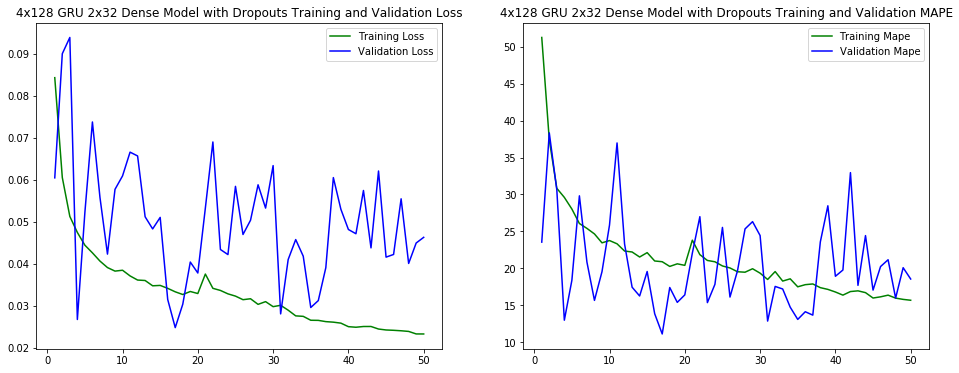

In [38]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation MAPE')
plt.legend()
plt.show()

In [29]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 2.480317
Validation MAE = 2.641168


In [27]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=True)
as5_train_preds.shape

(18304, 1)

In [28]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(20000, 1)

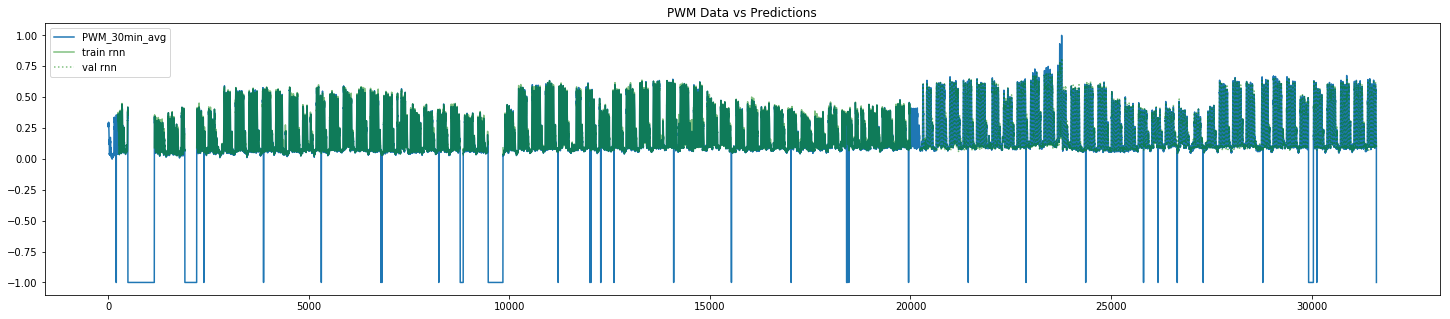

In [31]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

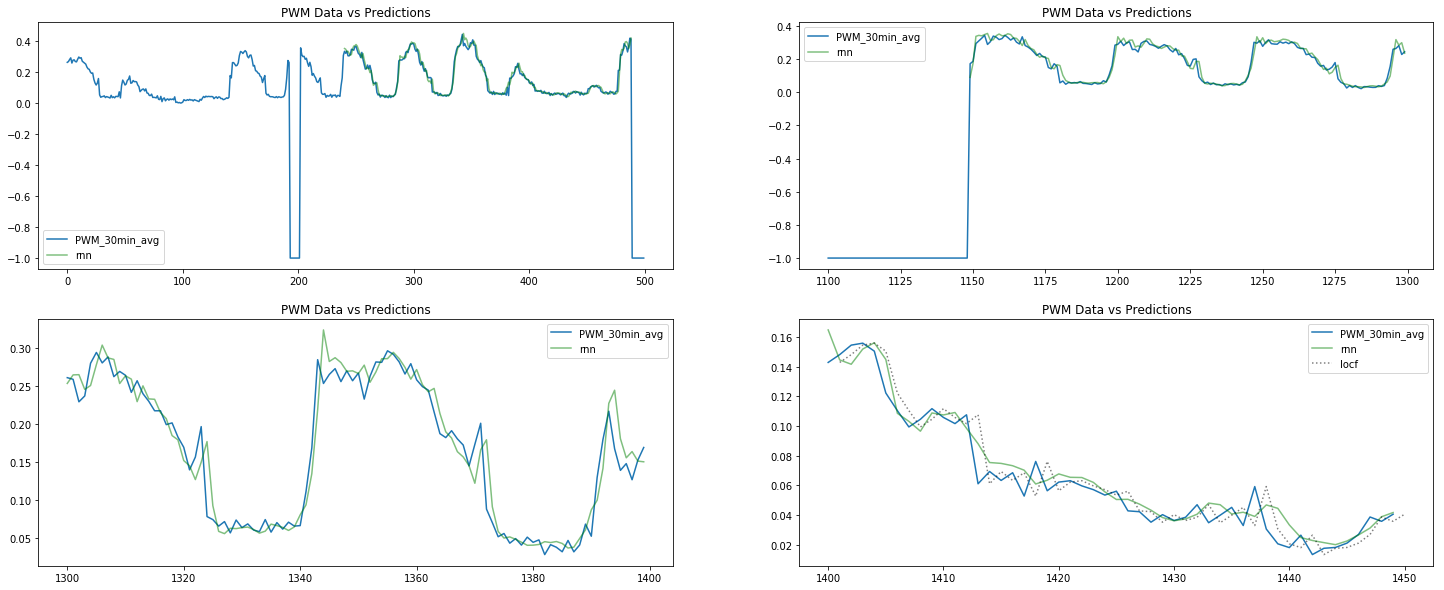

In [32]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [27]:
model.save('base-4x128gru-2x32dense-dropout0200.h5')

In [28]:
with open('base-4x128gru-2x32dense-dropout0200-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with No Dropout and Recurrent Dropout (0.2)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', recurrent_dropout=0.2, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', recurrent_dropout=0.2, reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [22]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [ ]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout0002-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout0002.h5'))
model.summary()

In [49]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50


Epoch 1/50


Epoch 1/50


 - 87s - loss: 0.0158 - mean_absolute_percentage_error: 10.8200 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 8.8066


Epoch 2/50


 - 88s - loss: 0.0157 - mean_absolute_percentage_error: 10.5927 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 9.3073


Epoch 3/50


 - 88s - loss: 0.0157 - mean_absolute_percentage_error: 10.7837 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 9.6431


Epoch 4/50


 - 88s - loss: 0.0156 - mean_absolute_percentage_error: 10.8850 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 9.6518


Epoch 5/50


 - 87s - loss: 0.0156 - mean_absolute_percentage_error: 10.9558 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 9.6858


Epoch 6/50


 - 87s - loss: 0.0155 - mean_absolute_percentage_error: 10.7372 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 9.1714


Epoch 7/50


 - 87s - loss: 0.0156 - mean_absolute_percentage_error: 10.7732 - val_loss: 0.0242 - val_mean_absolute_percentage_error: 13.9883


Epoch 8/50


 - 87s - loss: 0.0155 - mean_absolute_percentage_error: 10.8325 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 8.8525


Epoch 9/50


 - 87s - loss: 0.0155 - mean_absolute_percentage_error: 10.6818 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 10.5478


Epoch 10/50


 - 87s - loss: 0.0155 - mean_absolute_percentage_error: 10.5877 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 10.5059


Epoch 11/50


 - 87s - loss: 0.0155 - mean_absolute_percentage_error: 10.6209 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 9.0055


Epoch 12/50


 - 87s - loss: 0.0155 - mean_absolute_percentage_error: 10.6874 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 9.8163


Epoch 13/50


 - 86s - loss: 0.0153 - mean_absolute_percentage_error: 10.7618 - val_loss: 0.0189 - val_mean_absolute_percentage_error: 8.6641


Epoch 14/50


 - 86s - loss: 0.0153 - mean_absolute_percentage_error: 10.8102 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 9.0553


Epoch 15/50


 - 87s - loss: 0.0152 - mean_absolute_percentage_error: 10.3616 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 8.6982


Epoch 16/50


 - 86s - loss: 0.0152 - mean_absolute_percentage_error: 10.7154 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 8.9173


Epoch 17/50


 - 87s - loss: 0.0152 - mean_absolute_percentage_error: 10.5983 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 10.4649


Epoch 18/50


 - 87s - loss: 0.0152 - mean_absolute_percentage_error: 10.4986 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 9.0330


Epoch 19/50


 - 87s - loss: 0.0151 - mean_absolute_percentage_error: 10.5215 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 8.7426


Epoch 20/50


 - 88s - loss: 0.0150 - mean_absolute_percentage_error: 10.4415 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 10.2467


Epoch 21/50


 - 87s - loss: 0.0150 - mean_absolute_percentage_error: 10.4082 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 9.1361


Epoch 22/50


 - 87s - loss: 0.0151 - mean_absolute_percentage_error: 10.3721 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 8.8795


Epoch 23/50


 - 87s - loss: 0.0148 - mean_absolute_percentage_error: 10.3732 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 8.9106


Epoch 24/50


 - 87s - loss: 0.0148 - mean_absolute_percentage_error: 10.2422 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 9.3097


Epoch 25/50


 - 87s - loss: 0.0150 - mean_absolute_percentage_error: 10.4804 - val_loss: 0.0187 - val_mean_absolute_percentage_error: 9.3111


Epoch 26/50


 - 87s - loss: 0.0149 - mean_absolute_percentage_error: 10.2715 - val_loss: 0.0209 - val_mean_absolute_percentage_error: 11.2292


Epoch 27/50


 - 87s - loss: 0.0149 - mean_absolute_percentage_error: 10.4135 - val_loss: 0.0206 - val_mean_absolute_percentage_error: 8.9801


Epoch 28/50


 - 87s - loss: 0.0147 - mean_absolute_percentage_error: 10.2207 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 8.8305


Epoch 29/50


 - 87s - loss: 0.0147 - mean_absolute_percentage_error: 10.2066 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 10.1136


Epoch 30/50


 - 87s - loss: 0.0147 - mean_absolute_percentage_error: 10.0973 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 12.1086


Epoch 31/50


 - 86s - loss: 0.0148 - mean_absolute_percentage_error: 10.2487 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 9.3236


Epoch 32/50


 - 86s - loss: 0.0146 - mean_absolute_percentage_error: 10.0608 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 10.5951


Epoch 33/50


 - 87s - loss: 0.0146 - mean_absolute_percentage_error: 10.1042 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 9.2985


Epoch 34/50


 - 86s - loss: 0.0147 - mean_absolute_percentage_error: 10.2127 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 8.8472


Epoch 35/50


 - 87s - loss: 0.0147 - mean_absolute_percentage_error: 10.1127 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 9.3444


Epoch 36/50


 - 87s - loss: 0.0145 - mean_absolute_percentage_error: 9.9344 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 10.4945


Epoch 37/50


 - 86s - loss: 0.0145 - mean_absolute_percentage_error: 10.0337 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 10.2990


Epoch 38/50


 - 86s - loss: 0.0144 - mean_absolute_percentage_error: 10.2033 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 8.9608


Epoch 39/50


 - 87s - loss: 0.0144 - mean_absolute_percentage_error: 10.0721 - val_loss: 0.0228 - val_mean_absolute_percentage_error: 10.2719


Epoch 40/50


 - 88s - loss: 0.0145 - mean_absolute_percentage_error: 10.2058 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 10.1445


Epoch 41/50


 - 88s - loss: 0.0144 - mean_absolute_percentage_error: 9.9969 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 8.9810


Epoch 42/50


 - 87s - loss: 0.0143 - mean_absolute_percentage_error: 9.9378 - val_loss: 0.0207 - val_mean_absolute_percentage_error: 9.0890


Epoch 43/50


 - 87s - loss: 0.0142 - mean_absolute_percentage_error: 9.9270 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 10.5699


Epoch 44/50


 - 87s - loss: 0.0141 - mean_absolute_percentage_error: 9.8470 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 10.4775


Epoch 45/50


 - 87s - loss: 0.0142 - mean_absolute_percentage_error: 9.9480 - val_loss: 0.0221 - val_mean_absolute_percentage_error: 9.6116


Epoch 46/50


 - 87s - loss: 0.0143 - mean_absolute_percentage_error: 9.8142 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 9.4486


Epoch 47/50


 - 87s - loss: 0.0141 - mean_absolute_percentage_error: 9.8870 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 9.4787


Epoch 48/50


 - 87s - loss: 0.0142 - mean_absolute_percentage_error: 9.7393 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 8.8748


Epoch 49/50


 - 87s - loss: 0.0140 - mean_absolute_percentage_error: 9.7657 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 8.9728


Epoch 50/50


 - 87s - loss: 0.0142 - mean_absolute_percentage_error: 10.0320 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 8.9776



Training Duration = 1:12:26.506771


In [50]:
# histories = []  ## if first training session
histories.append(history.history)

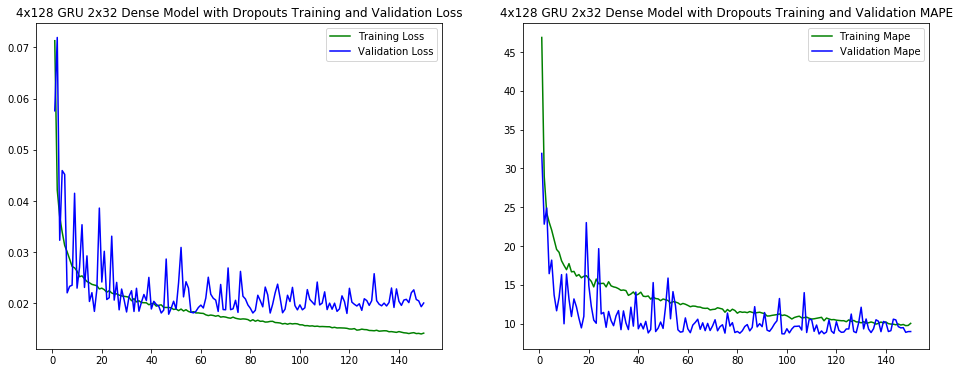

In [51]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation MAPE')
plt.legend()
plt.show()

In [52]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.493735
Validation MAE = 1.904215


In [53]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=True)
as5_train_preds.shape

(29754, 1)

In [54]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

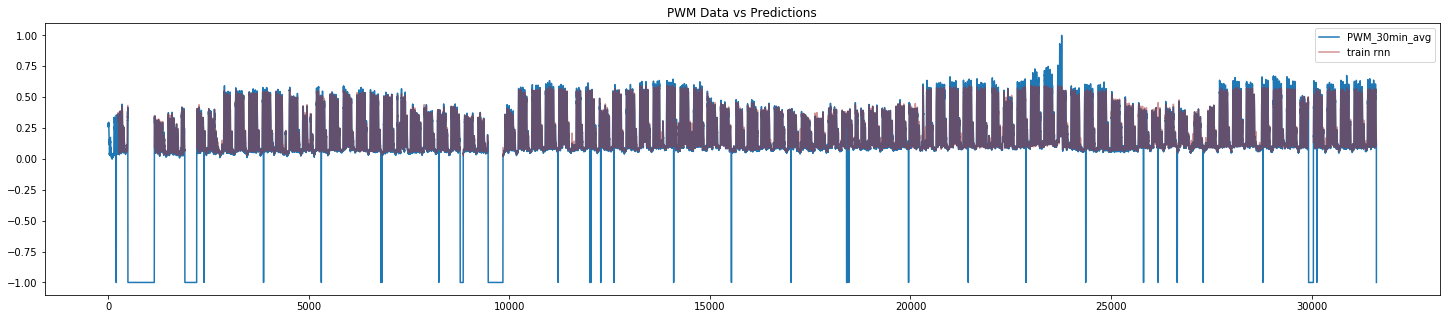

In [55]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

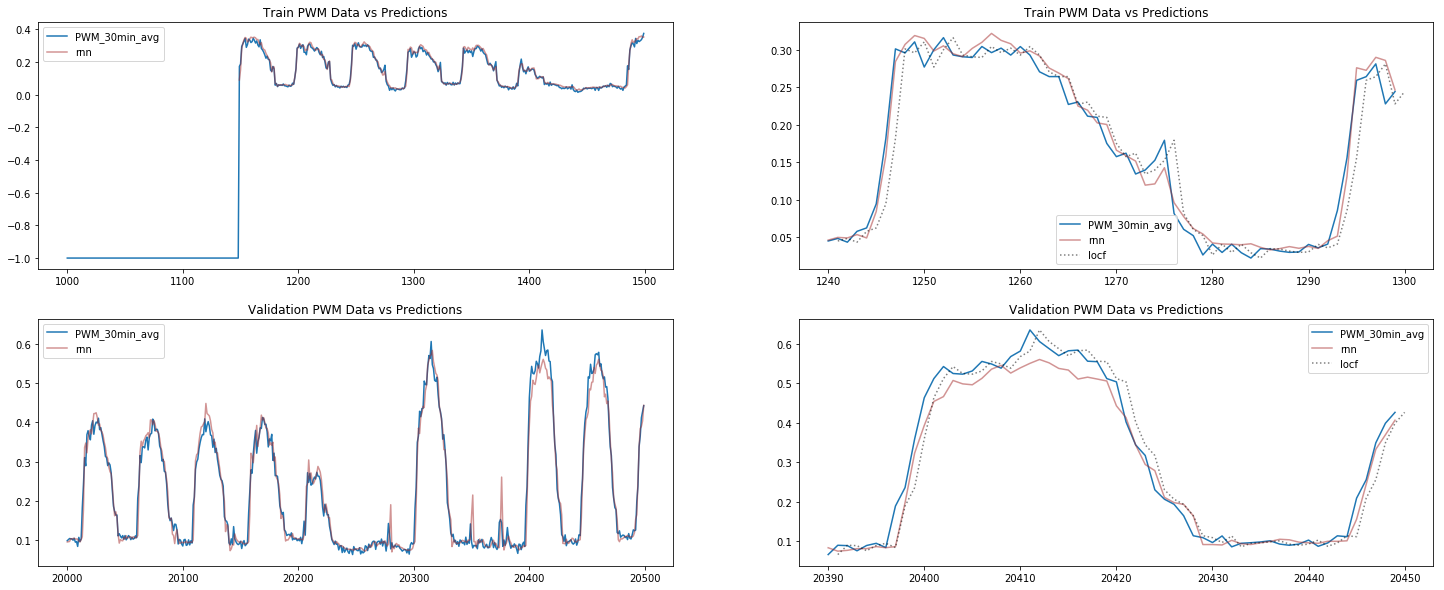

In [56]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [57]:
model.save('base-4x128gru-2x32dense-dropout0002.h5')

In [58]:
with open('base-4x128gru-2x32dense-dropout0002-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)